# Code 7: Bayesian Additive Regression Trees

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [1]:
%matplotlib inline
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import arviz as az
from scipy.special import expit

from scr.pdp import plot_pdp

In [2]:
az.style.use('arviz-grayscale')
plt.rcParams["figure.dpi"] = 300
np.random.seed(5453)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

## BART Bikes

In [3]:
data = pd.read_csv("data/bikes_hour.csv")
data = data[::50]
data.sort_values(by='hour', inplace=True)
data.hour.values.astype(float)

X = np.atleast_2d(data["hour"]).T
Y = data["count"]

### Code 7.1

In [4]:
with pm.Model() as bart_g:
    σ = pm.HalfNormal('σ', Y.std())
    μ = pm.BART('μ', X, Y, m=50)
    y = pm.Normal('y', μ, σ, observed=Y)
    idata_bart_g = pm.sample(2000, chains=1, return_inferencedata=True)

The BART model is experimental. Use with caution.
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 33 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


### Figure 7.4

Text(0, 0.5, 'count')

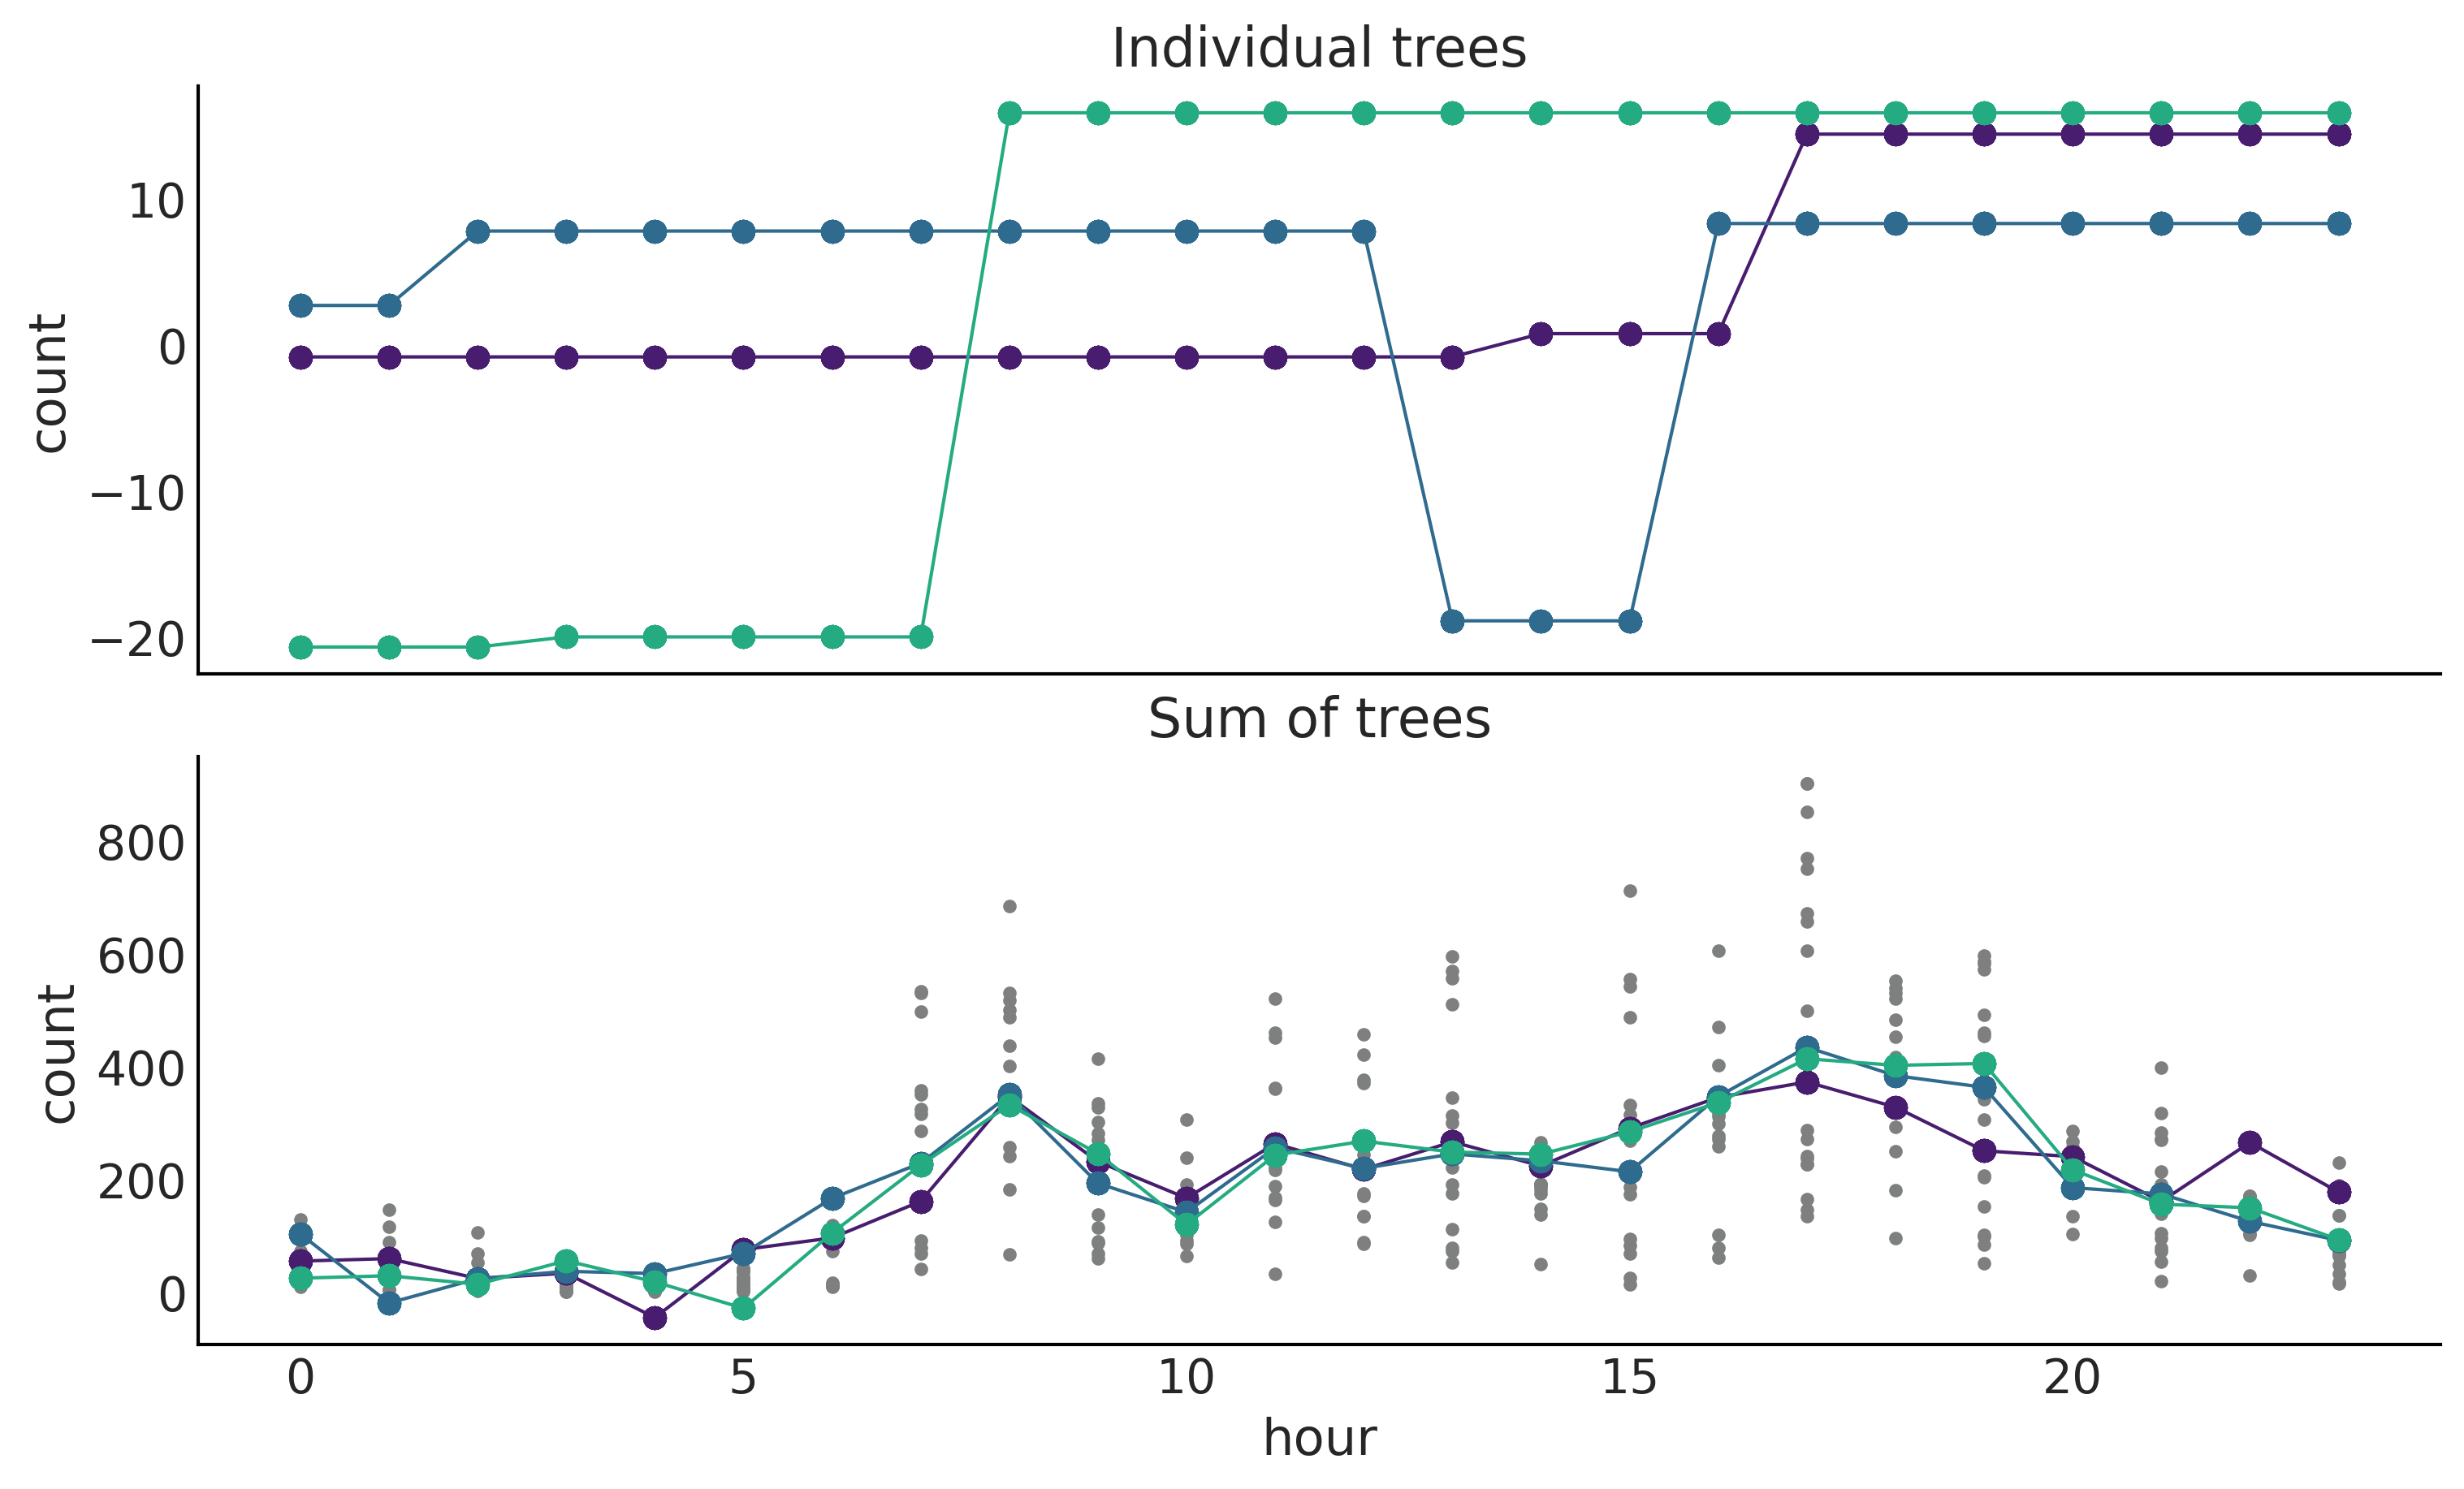

In [5]:
_, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].set_prop_cycle(cycler('color', viridish))
ax[1].set_prop_cycle(cycler('color', viridish))
for i in range(3):
    ax[0].plot(X, μ.distribution.all_trees[i*10][i*2].predict_output(), "o-", lw=1)

posterior = idata_bart_g.posterior.stack(samples=("chain", "draw"))
for i in range(3):
    ax[1].plot(X, posterior["μ"].sel(draw=i*50), "o-", lw=1)
ax[1].plot(X, Y, "C2.", zorder=-1)

    
ax[0].set_ylabel("count")
ax[0].set_title("Individual trees")
ax[1].set_title("Sum of trees")
ax[1].set_xlabel("hour")
ax[1].set_ylabel("count")
# plt.savefig('img/chp07/BART_bikes_samples.png')

### Code 7.5

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'count')

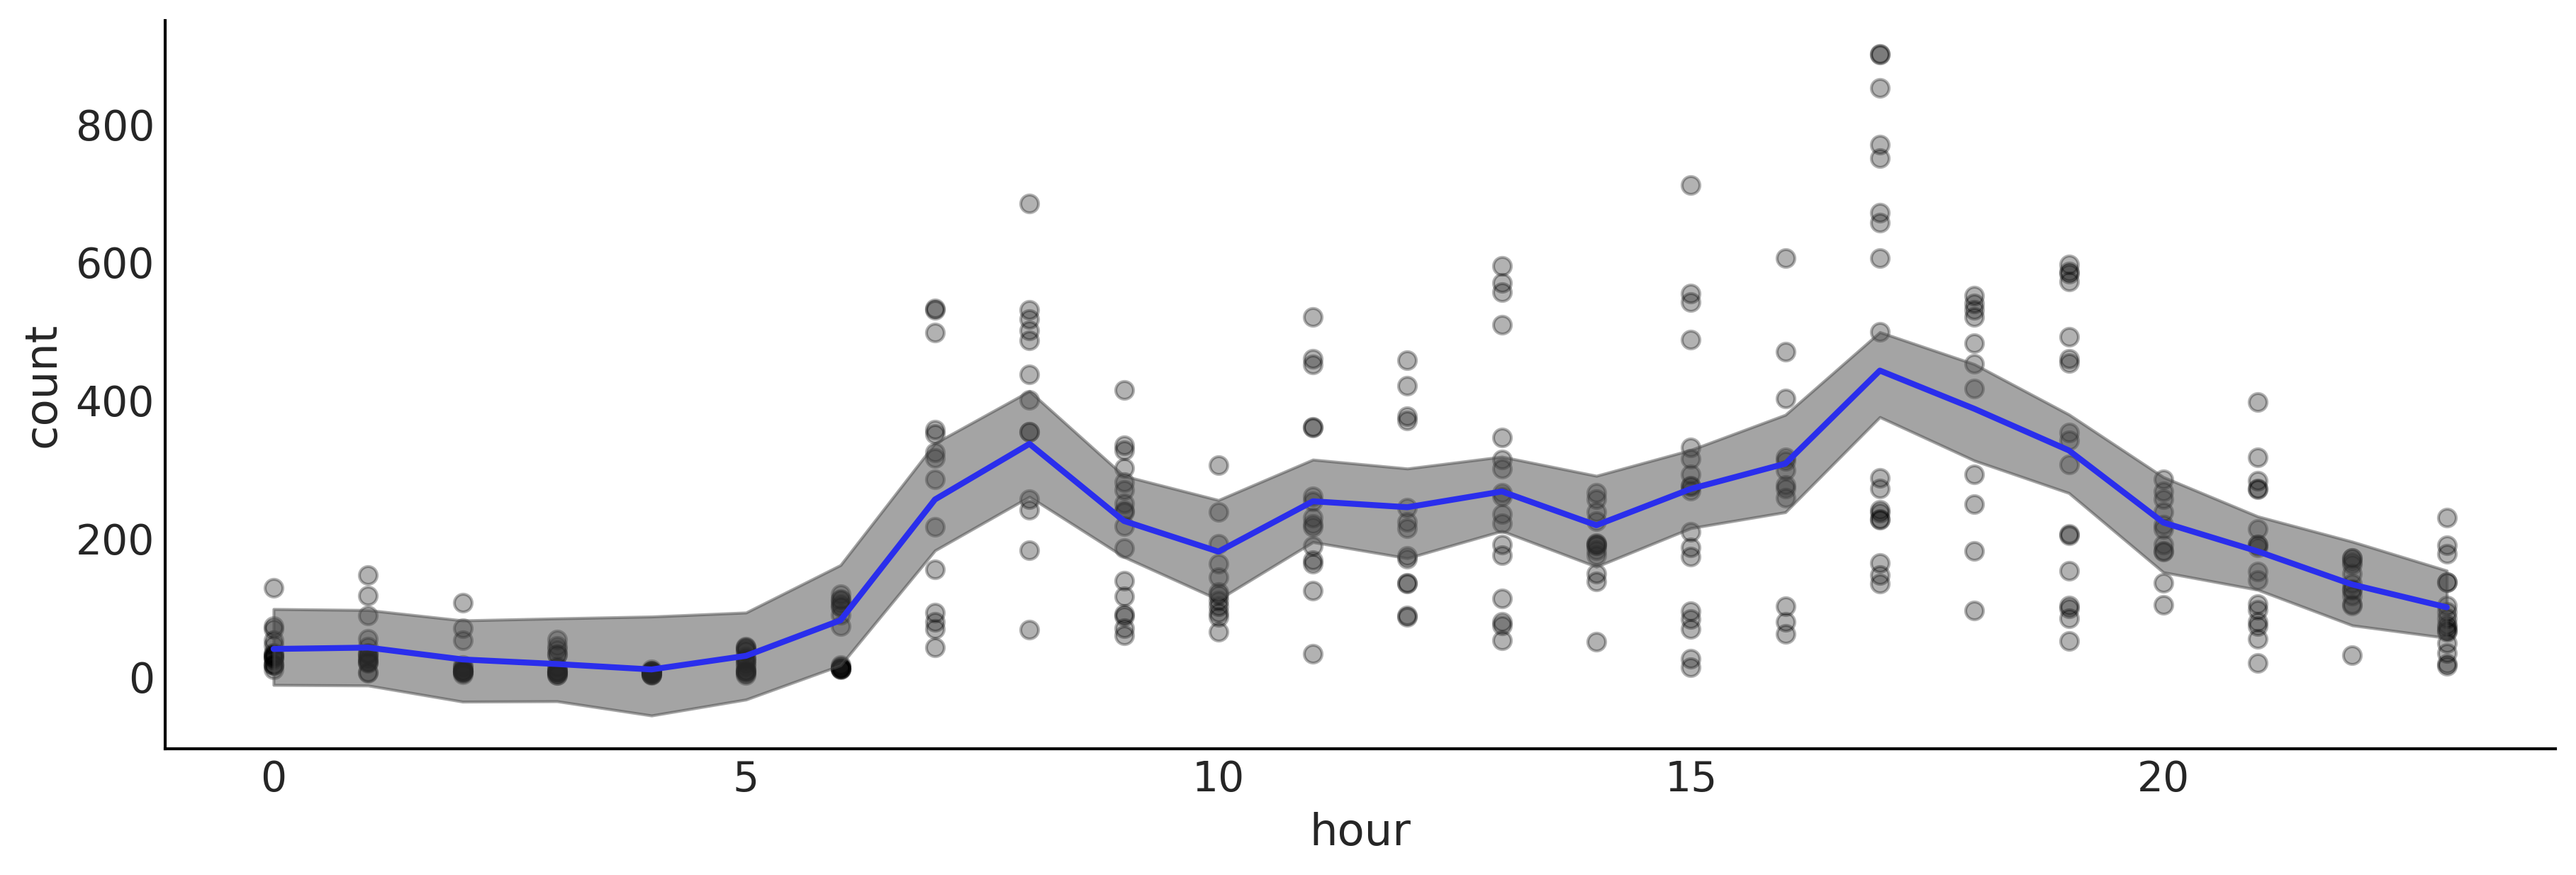

In [6]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(X, Y, "o", alpha=0.3, zorder=-1)
ax.plot(X,  posterior["μ"].mean("samples"), color="C4", lw=2)
az.plot_hdi(X[:,0], posterior["μ"].T, smooth=False)


ax.set_xlabel("hour")
ax.set_ylabel("count")
# plt.savefig('img/chp07/BART_bikes.png')

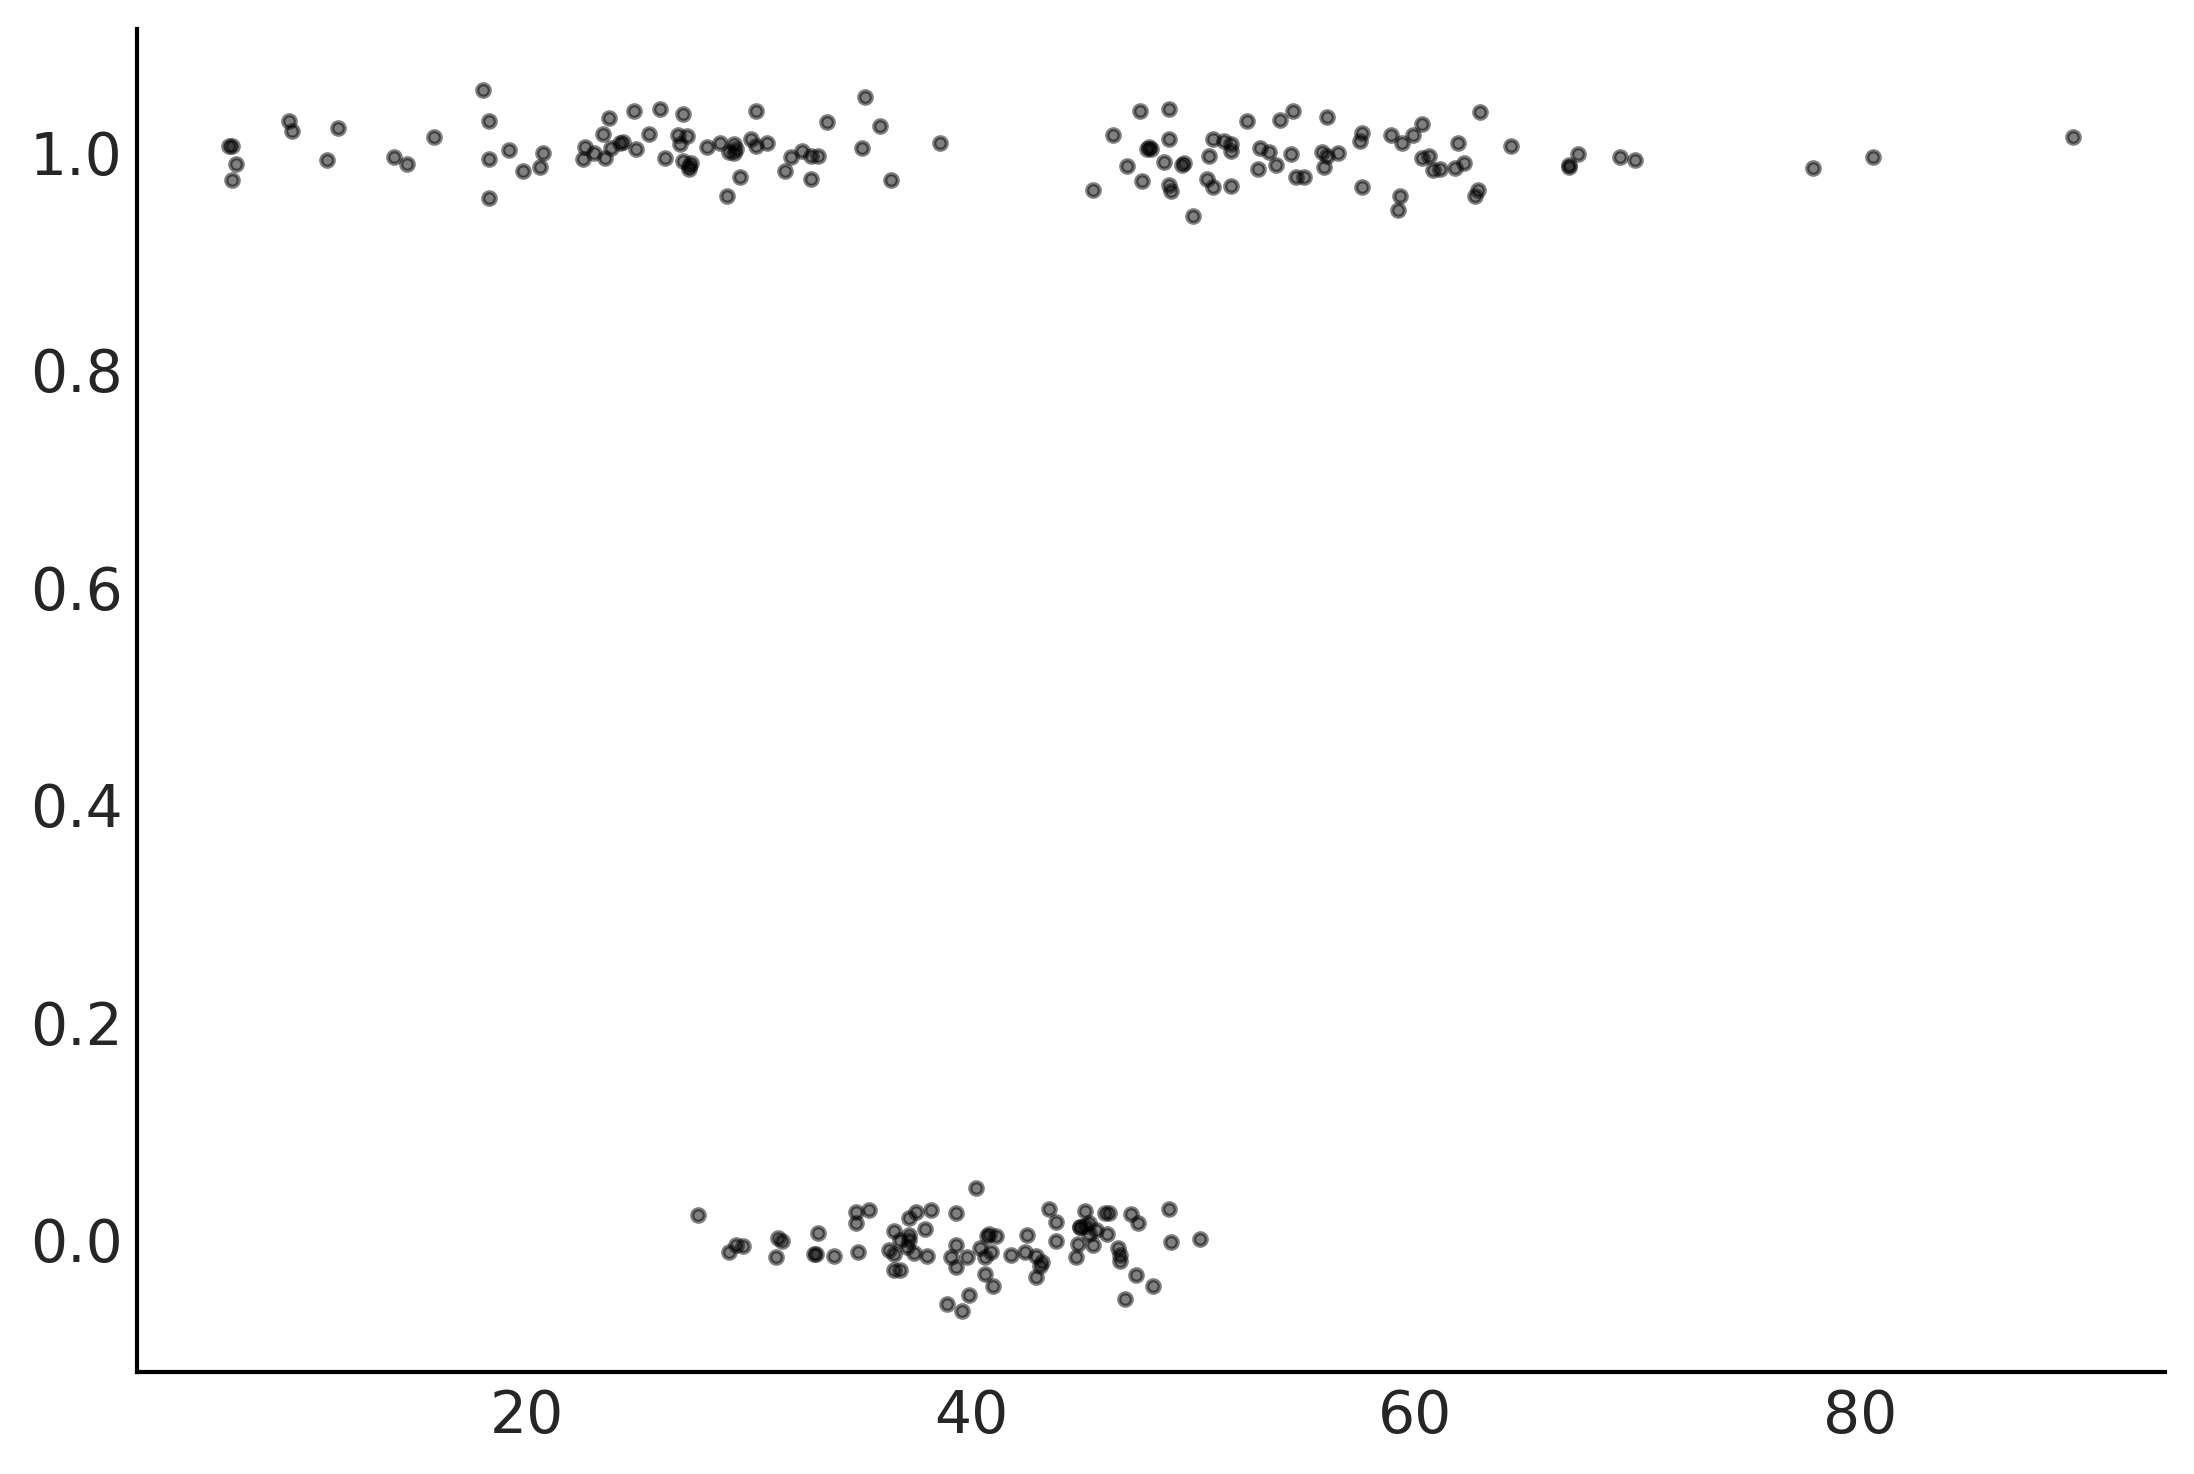

In [7]:
space_in = pd.read_csv("data/space_influenza.csv")
X = np.atleast_2d(space_in["age"]).T
Y = space_in["sick"]


Y_jittered = np.random.normal(Y, 0.02)
plt.plot(X[:,0], Y_jittered, ".", alpha=0.5)

## Generalized BART Models

### Code 7.2 and Figures 7.6 and 7.7

In [8]:
traces = []
ntrees = [2, 10, 20, 50]
for ntree in ntrees:
    with pm.Model() as bart_b:
        μ = pm.BART('μ', X, Y, m=ntree,
                    inv_link="logistic",
                   )
        y = pm.Bernoulli('y', μ, observed=Y)
        idata_bart_b = pm.sample(2000, return_inferencedata=True)
        traces.append(idata_bart_b)

The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
The number of effective samples is smaller than 10% for some parameters.
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
The number of effective samples is smaller than 10% for some parameters.
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [9]:
dict_cmp = dict(zip(("2", "10", "20", "50"), traces))
cmp = az.compare(dict_cmp)
cmp

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Es

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
10,0,-70.443958,12.819998,0.000000,1.000000e+00,7.387641,0.000000,False,log
20,1,-76.117821,23.610100,5.673862,5.684342e-14,9.853547,2.604116,True,log
2,2,-101.237317,9.563785,30.793358,0.000000e+00,3.655372,4.080170,True,log
50,3,-108.265255,59.810081,37.821296,0.000000e+00,16.374316,9.337263,True,log


<AxesSubplot:xlabel='Log'>

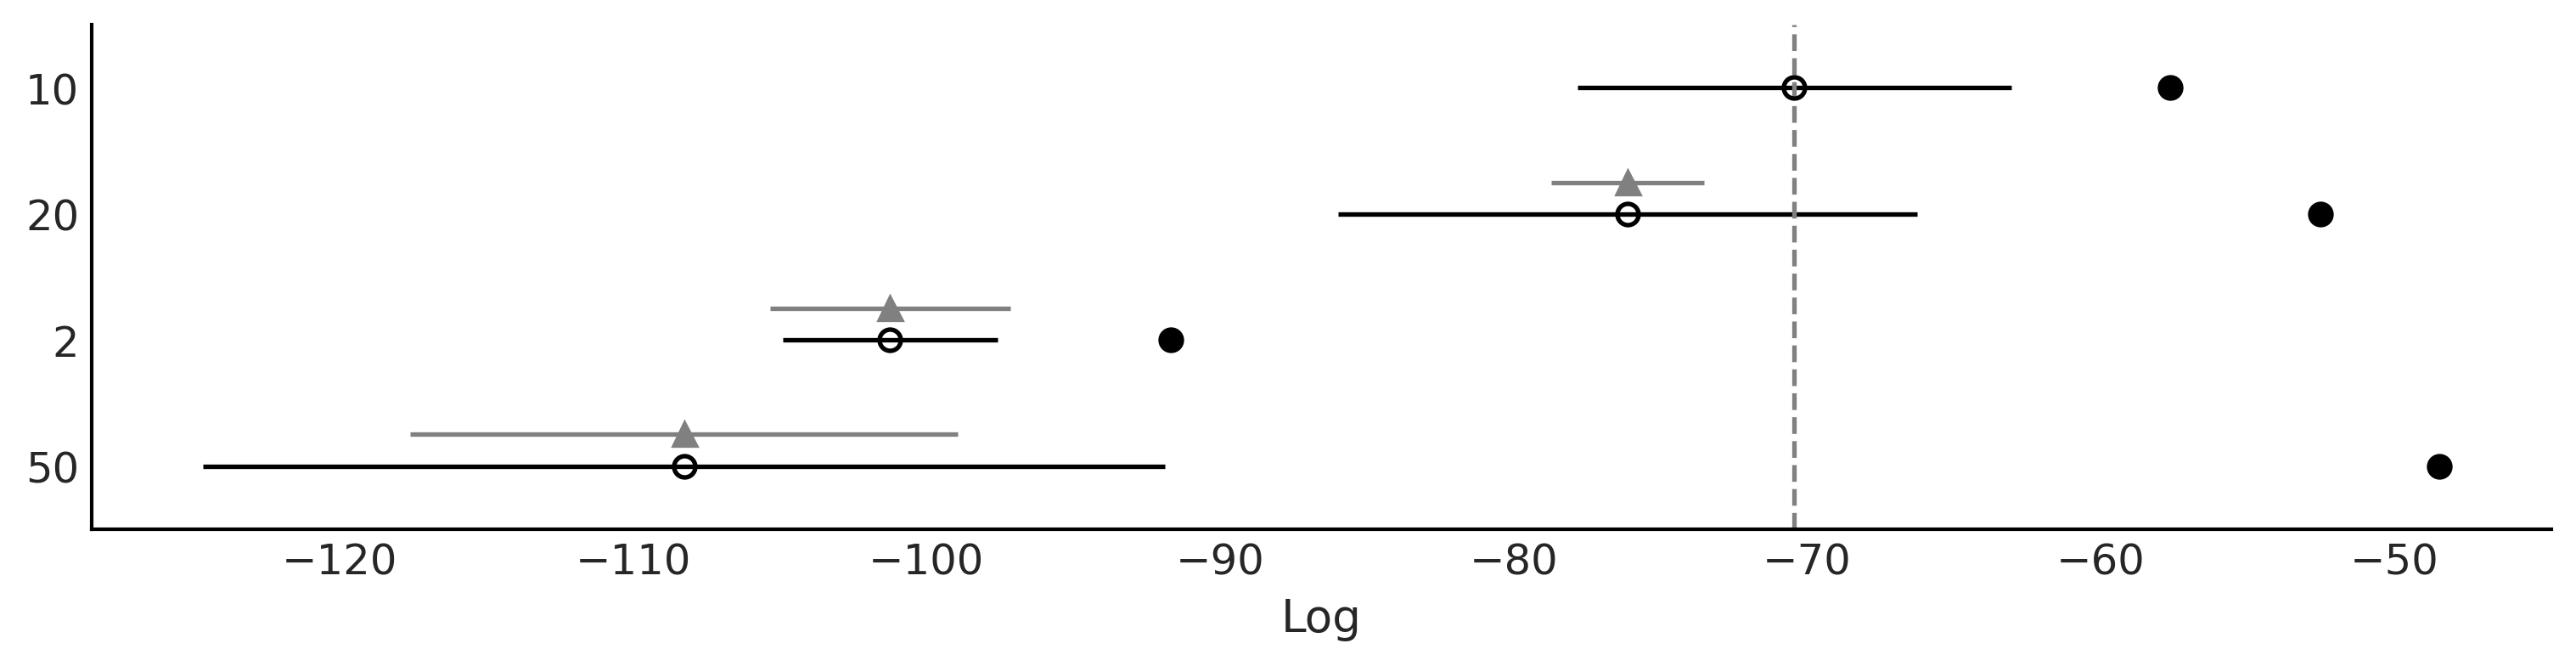

In [10]:
az.plot_compare(cmp, figsize=(10, 2.5))
# plt.savefig("img/chp07/BART_space_flu_comp.png")

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for 

Text(-0.03, 0.5, 'Space Influenza')

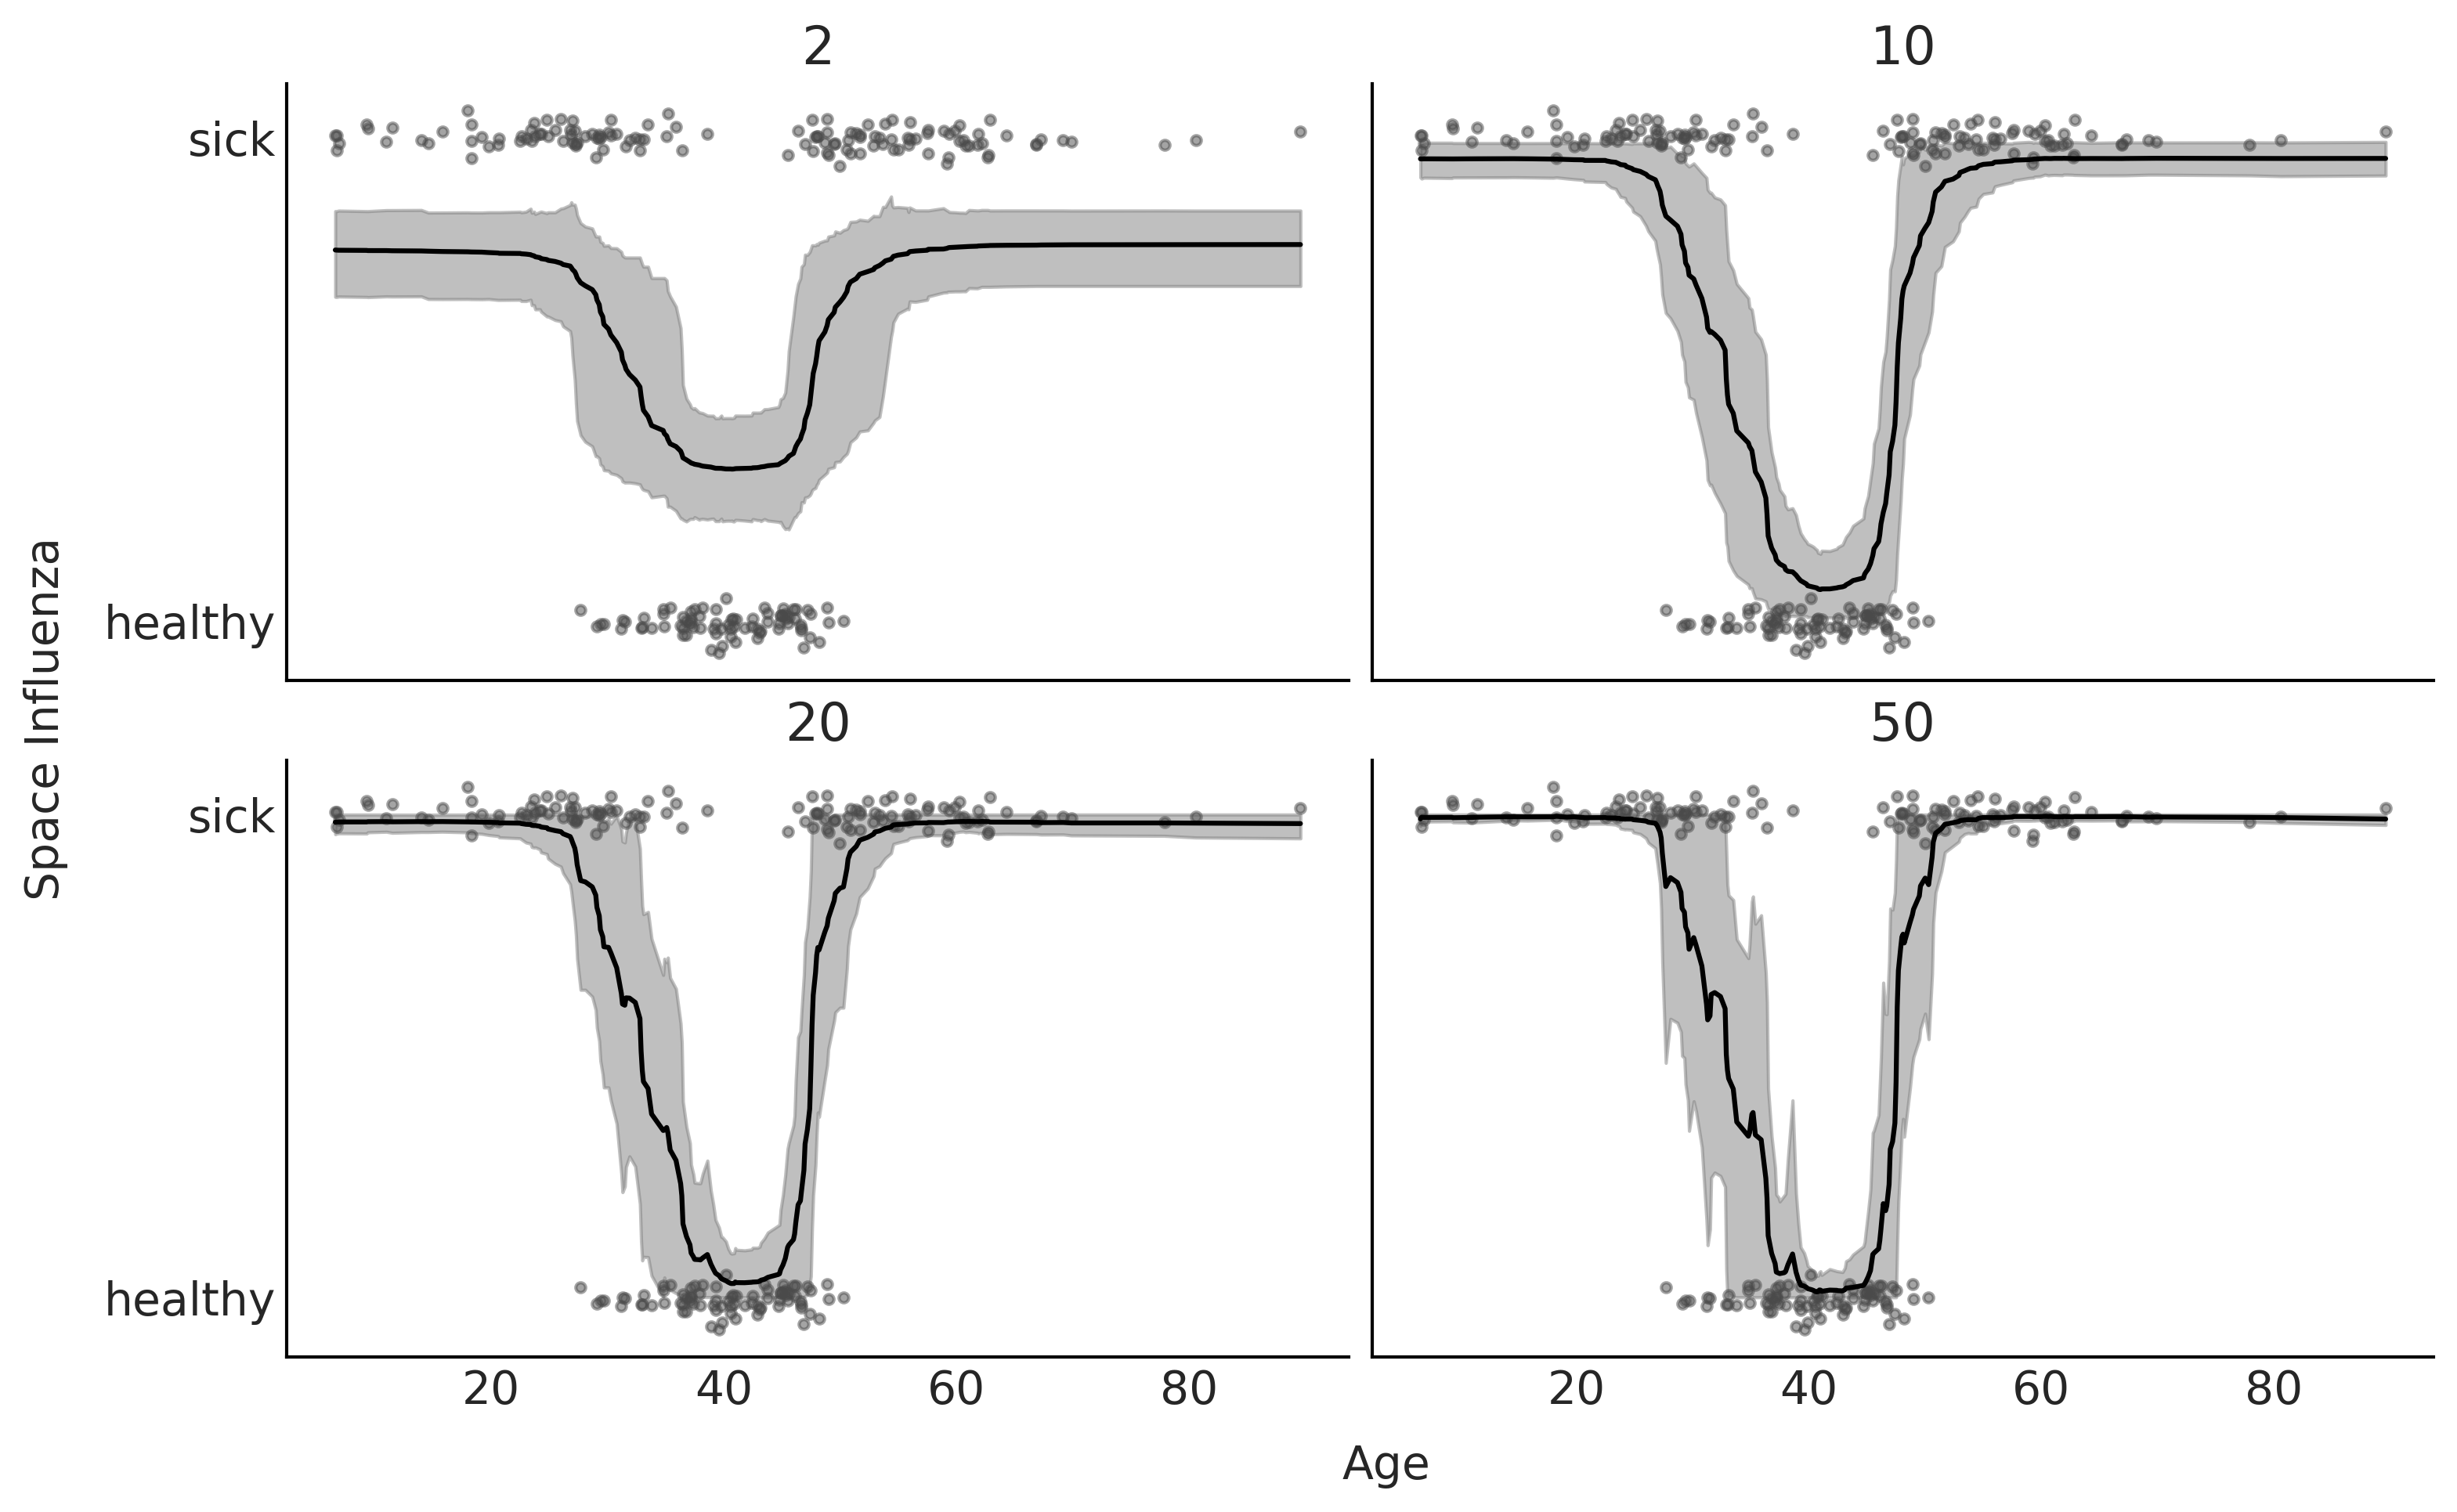

In [11]:
fig, axes = plt.subplots(2,2, figsize=(10, 6), sharey=True, sharex=True)

for ax, trace, mtree in zip(np.ravel(axes), traces, ntrees):
    μs = trace.posterior["μ"].stack({"draws":["chain",  "draw"]})

    ax.plot(X, Y_jittered, "C1.", alpha=0.5)

    X_idx = np.argsort(X[:,0])
    ax.plot(X[:,0][X_idx], np.mean(μs, 1)[X_idx], 'k-') 
    
    az.plot_hdi(X[:,0], μs.T, ax=ax, smooth=False, color="0.5") # una banda con el 94% Highest Density Interval
    ax.set_title(mtree)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["healthy", "sick"])
fig.text(0.55, -0.04, 'Age', ha='center', size=14)
fig.text(-0.03, 0.5, 'Space Influenza', va='center', size=14, rotation=90)
# plt.savefig("img/chp07/BART_space_flu_fit.png", bbox_inches="tight")

## Interpretability of BARTs

### Figure 7.8

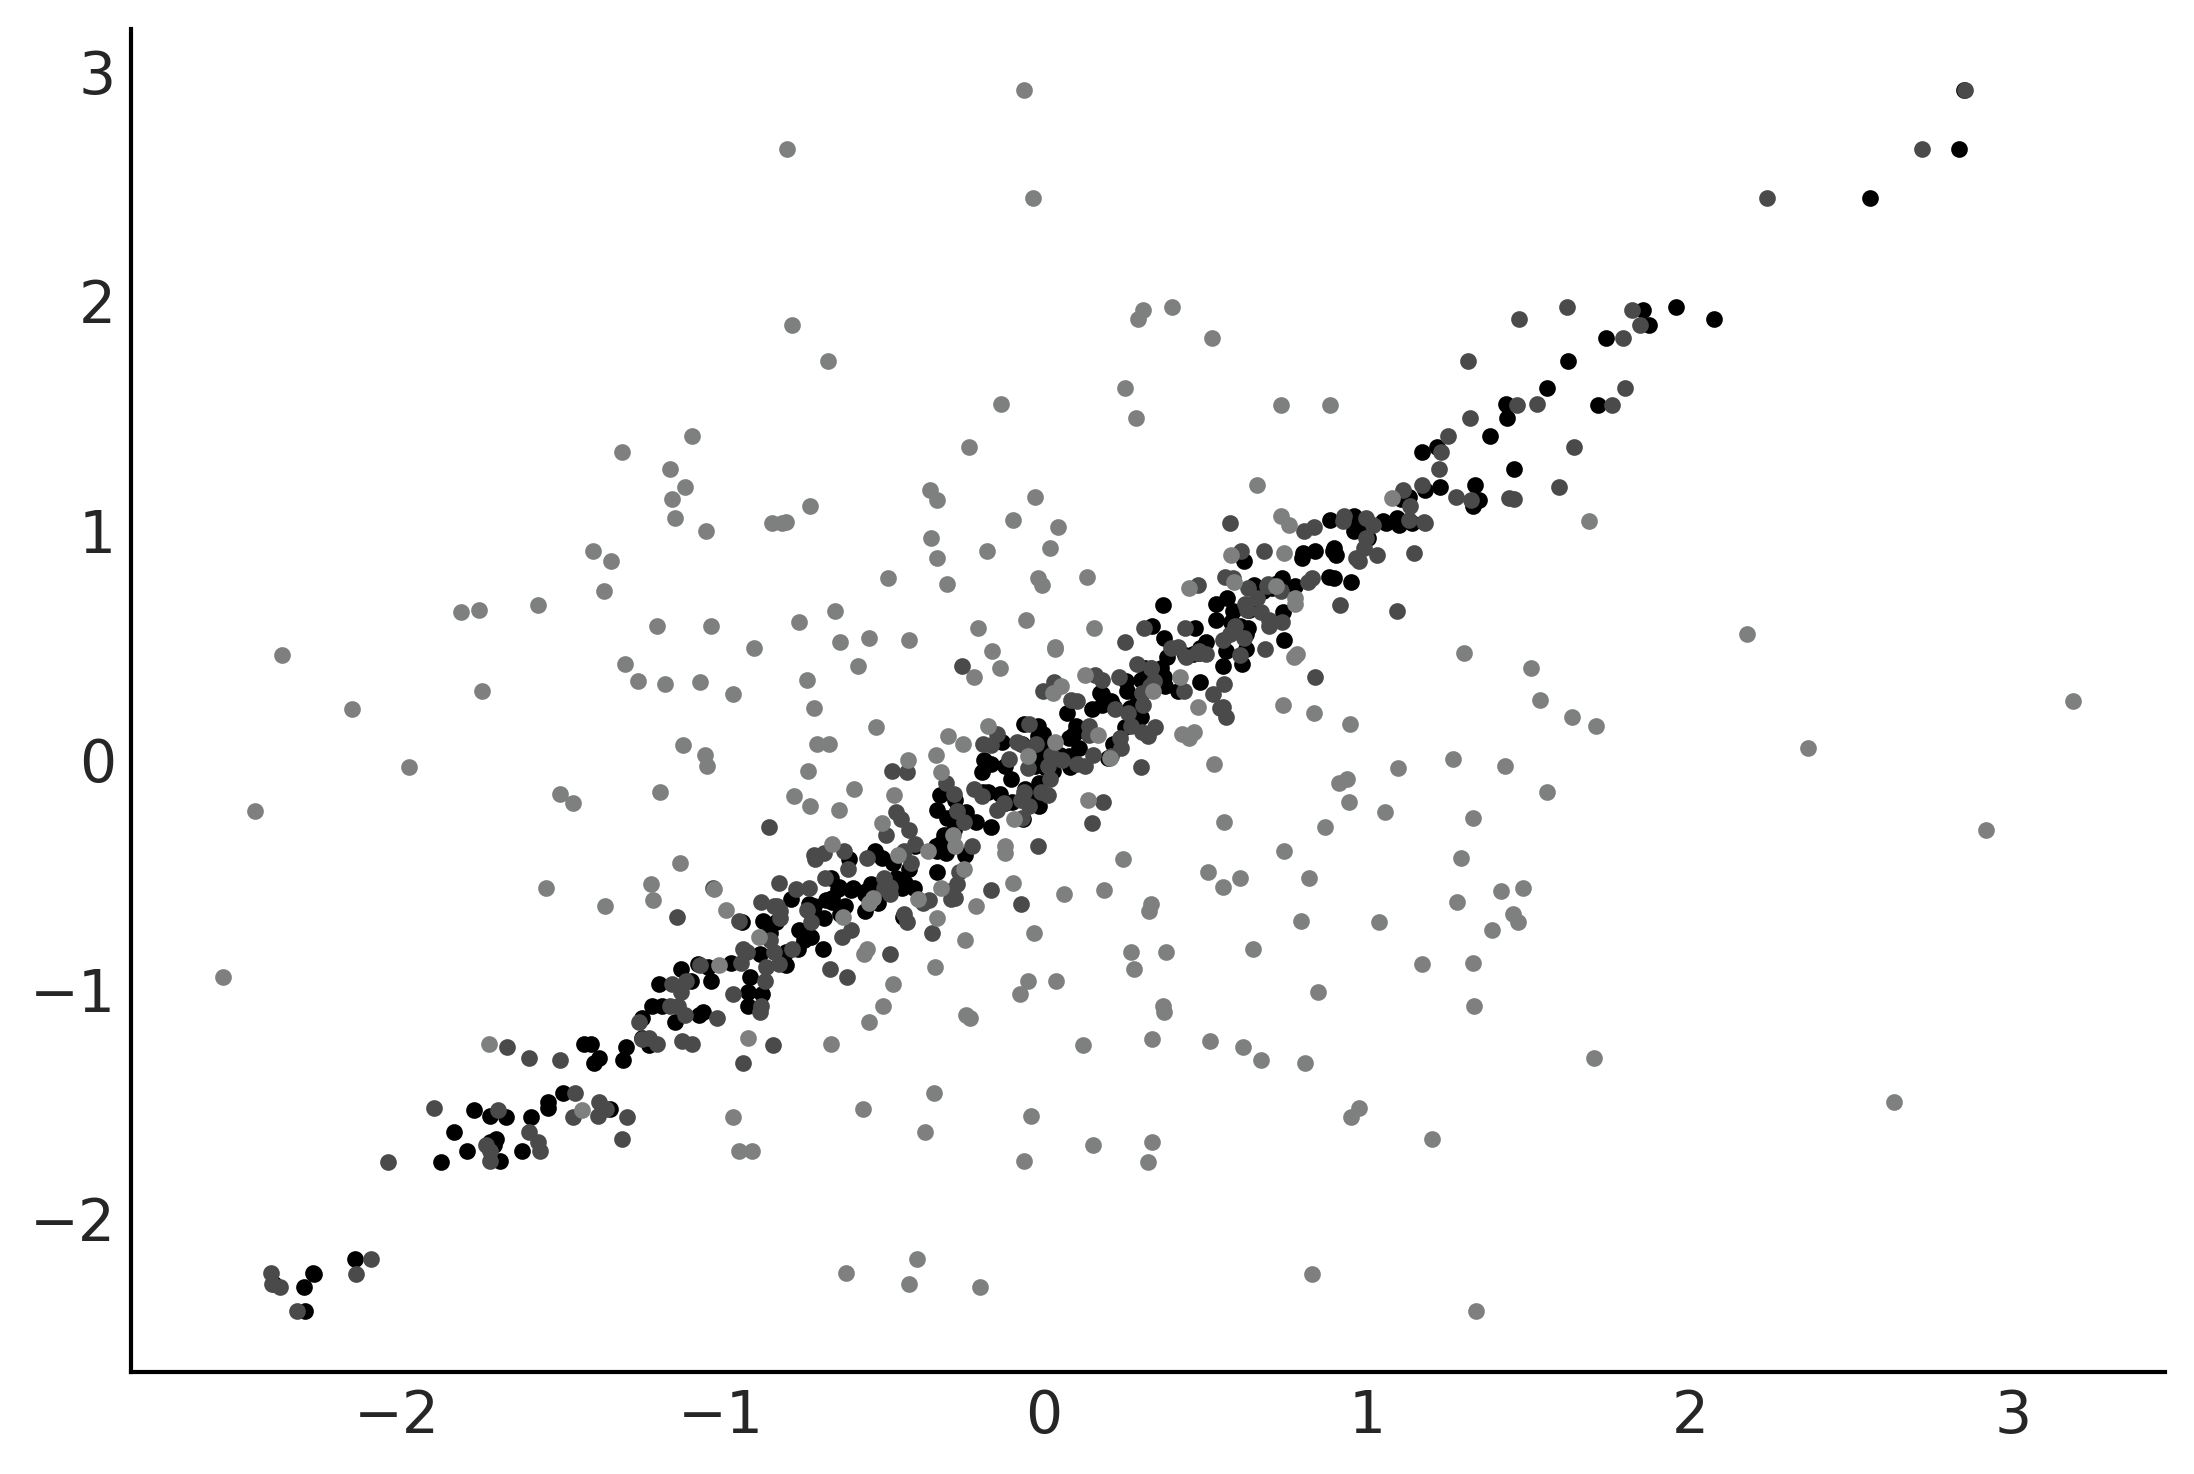

In [12]:
X = np.random.normal(0, 1, size=(3, 250)).T
Y = np.random.normal(0, 1, size=250)
X[:,0] = np.random.normal(Y, 0.1)
X[:,1] = np.random.normal(Y, 0.2)

plt.plot(X, Y, '.');

In [13]:
with pm.Model() as model:
    μ = pm.BART('μ', X, Y, m=50, alpha=0.25)
    σ = pm.HalfNormal('σ', 1)
    y = pm.Normal('y', μ, σ, observed=Y)
    trace_u = pm.sample(2000, tune=1000, chains=1, random_seed=42)

/tmp/ipykernel_270170/618026337.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_u = pm.sample(2000, tune=1000, chains=1, random_seed=42)
The BART model is experimental. Use with caution.
Sequential sampling (1 chains in 1 job)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.8933652542026335, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<AxesSubplot:xlabel='X_0'>, <AxesSubplot:xlabel='X_1'>,
       <AxesSubplot:xlabel='X_2'>], dtype=object)

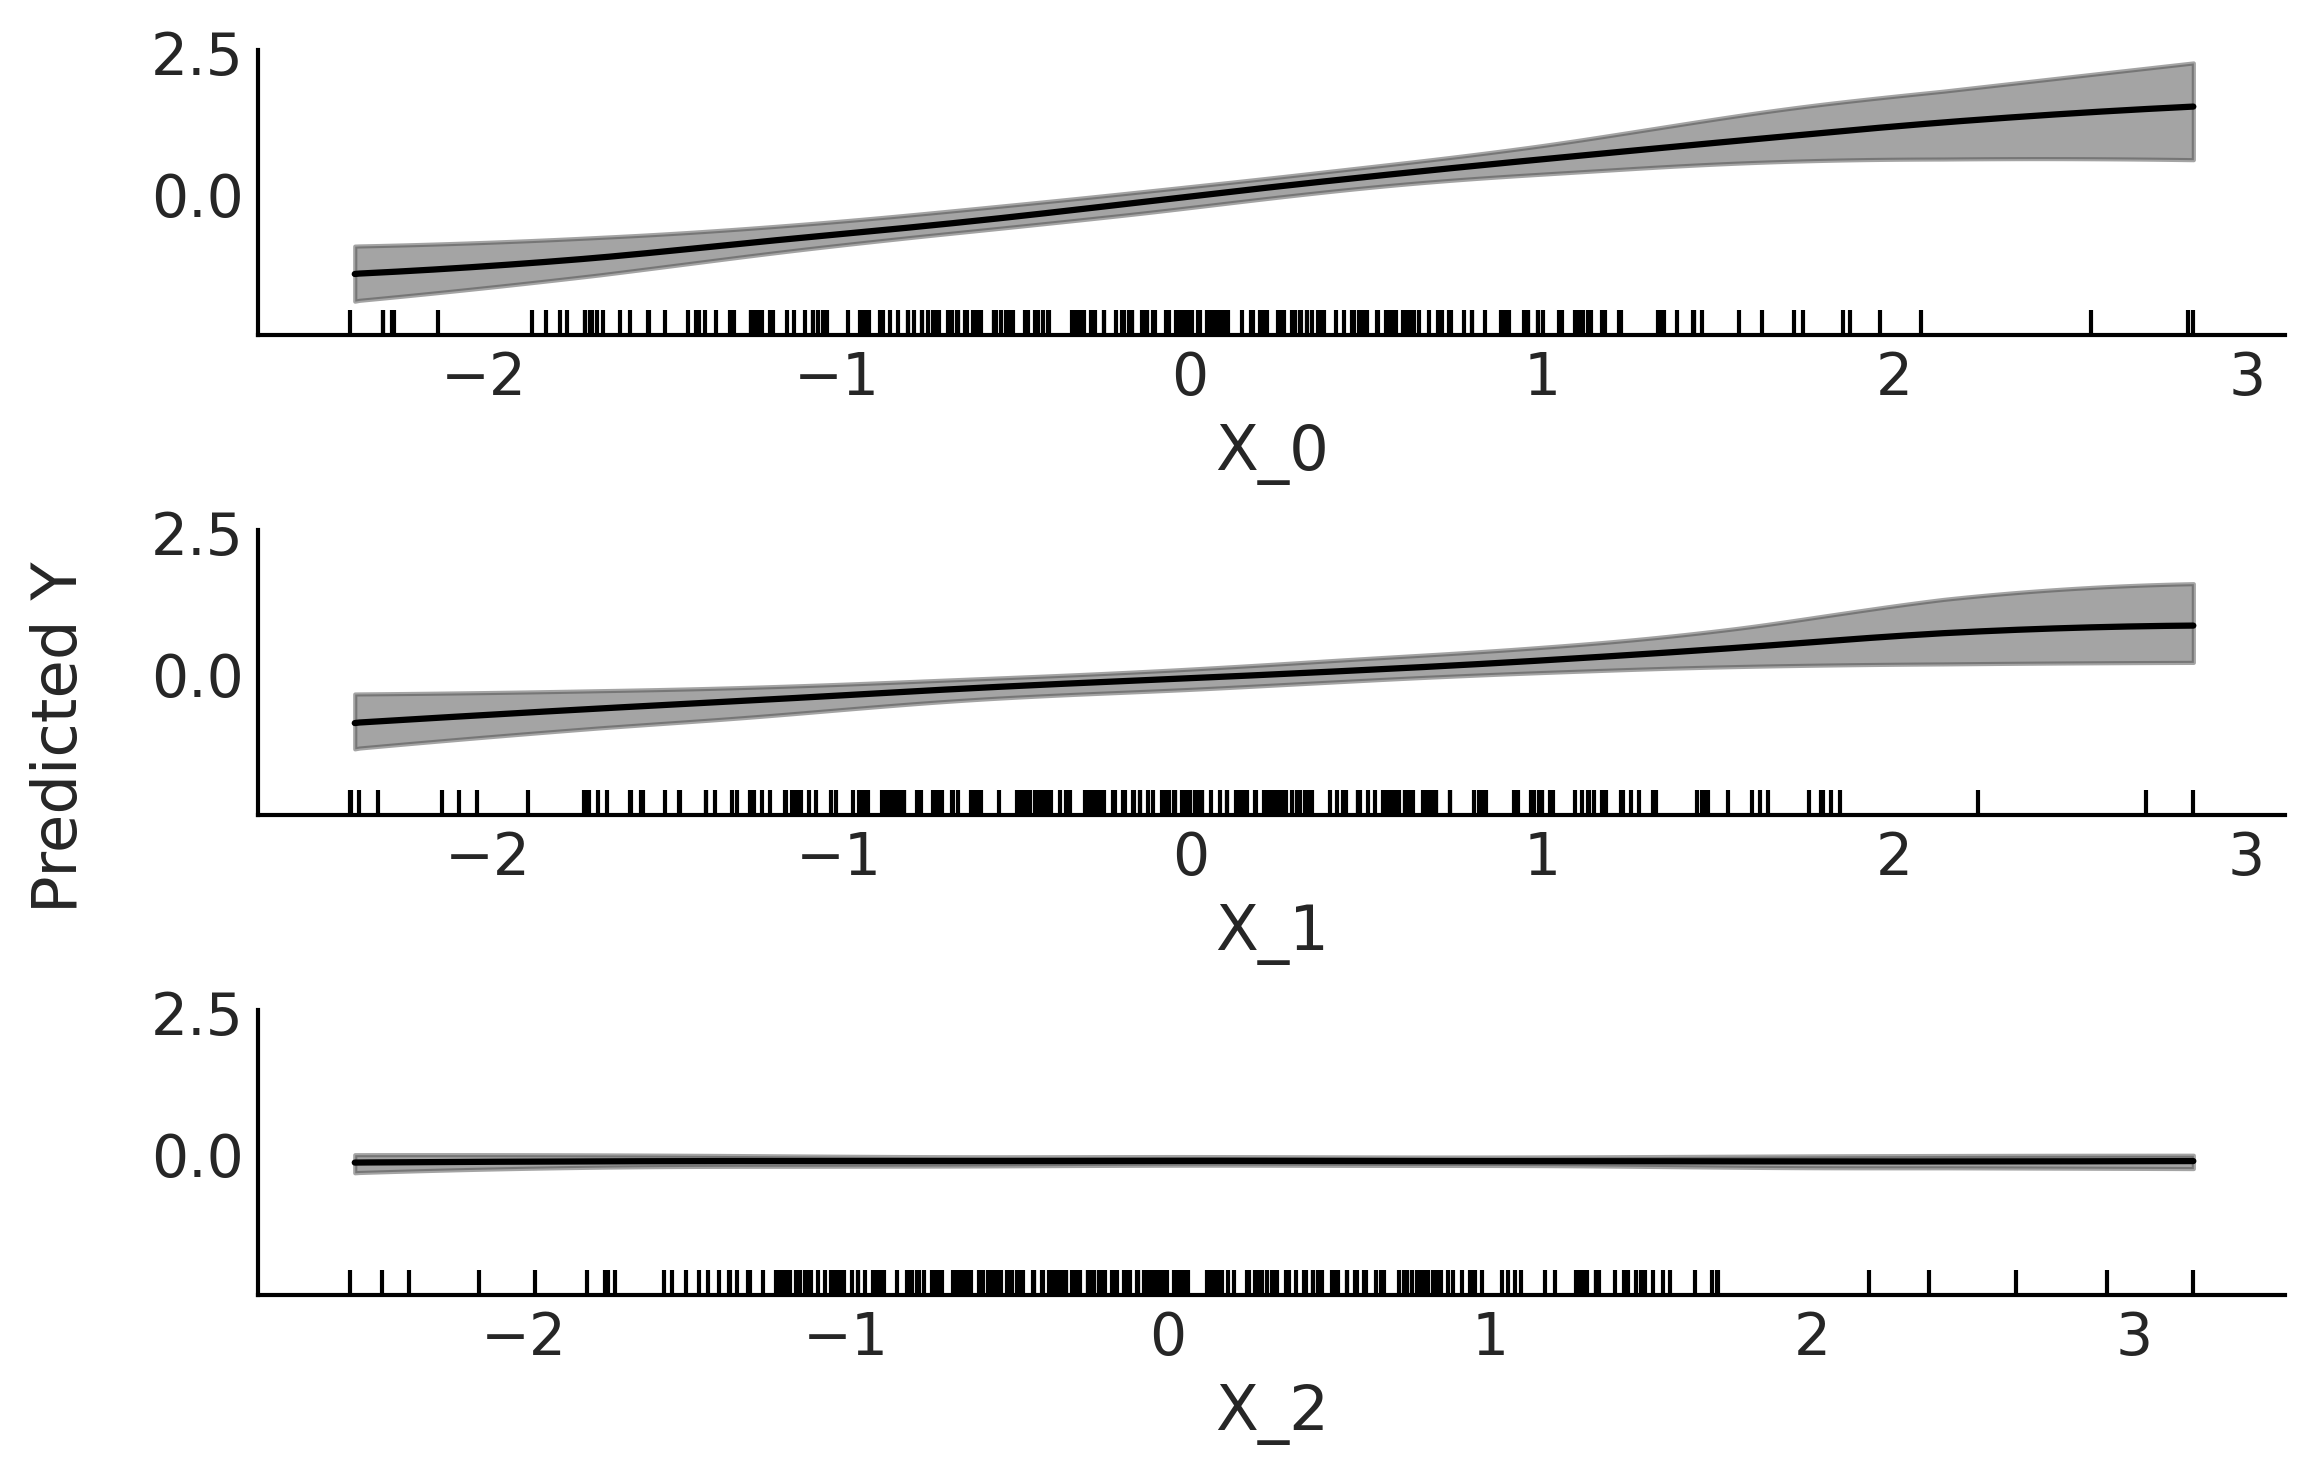

In [14]:
plot_pdp(μ, X, grid="long", subsample=10)
# plt.savefig("img/chp07/partial_dependence_plot.png", bbox_inches="tight")

### Figures 7.9, 7.10, and 7.11 

In [15]:
X = data[["hour", "temperature", "humidity", "windspeed"]]
Y = data["count"]

In [16]:
with pm.Model() as bart_model_g:
    σ = pm.HalfNormal('σ', Y.std())
    μ = pm.BART('μ', X, Y, m=50)
    y = pm.Normal('y', μ, σ, observed=Y)
    trace_bart = pm.sample(2000, chains=1)

/tmp/ipykernel_270170/616606607.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_bart = pm.sample(2000, chains=1)
The BART model is experimental. Use with caution.
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 33 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<AxesSubplot:xlabel='hour'>, <AxesSubplot:xlabel='temperature'>,
       <AxesSubplot:xlabel='humidity'>, <AxesSubplot:xlabel='windspeed'>],
      dtype=object)

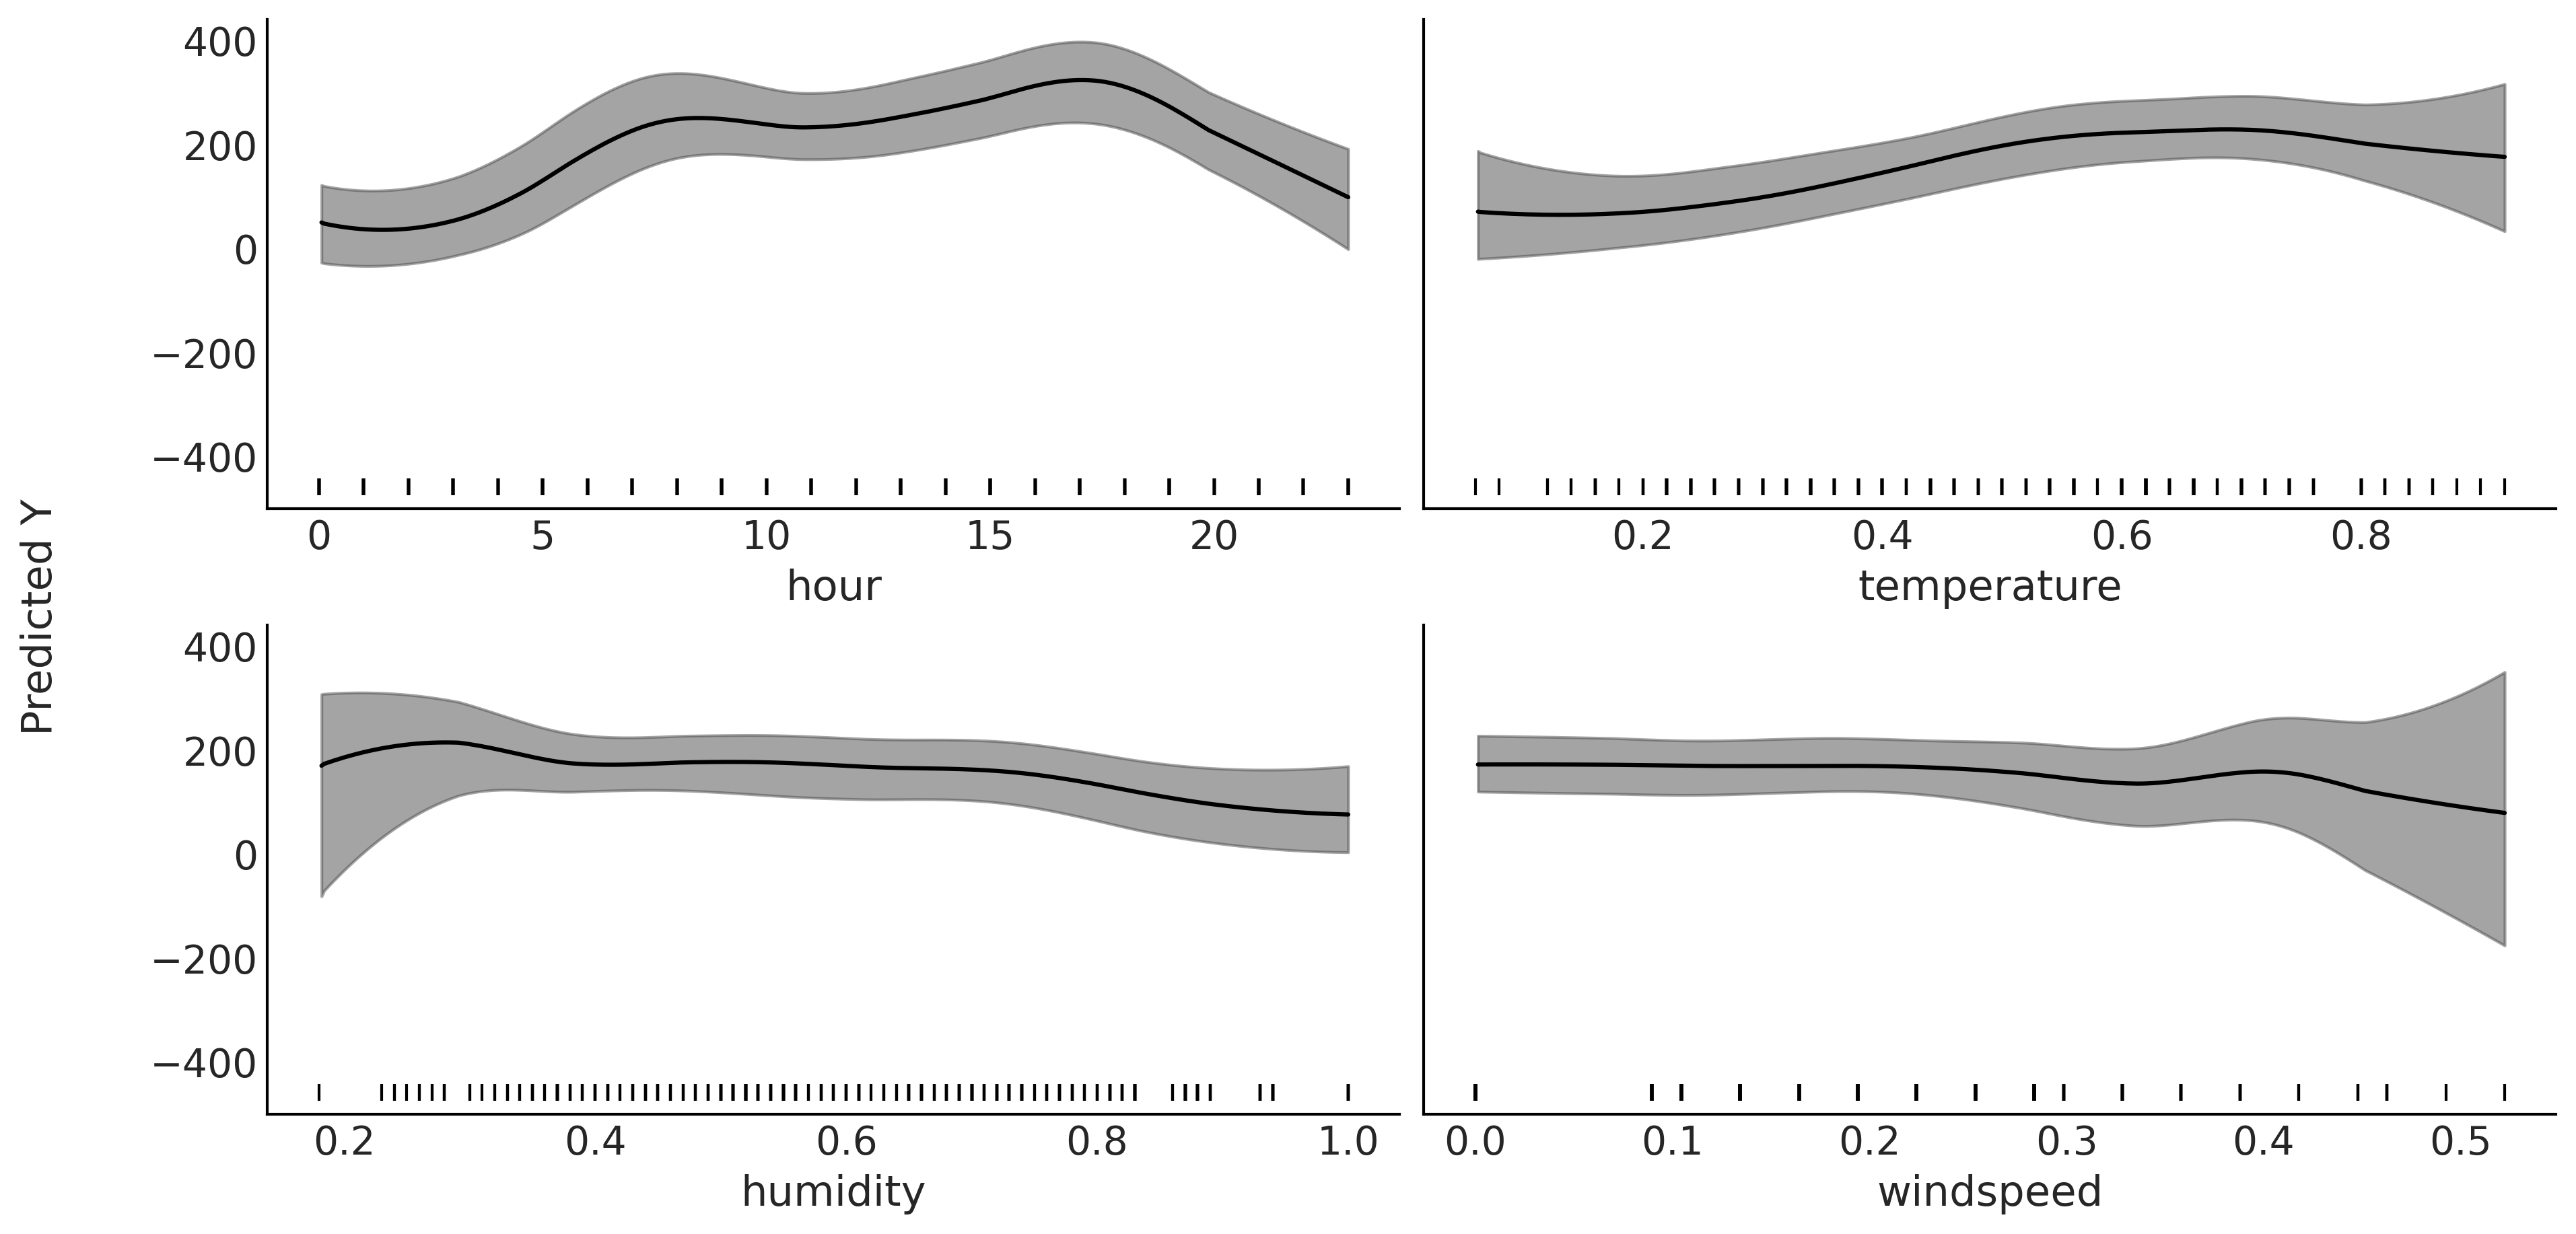

In [17]:
plot_pdp(μ, X, grid=(2, 2), figsize=(12, 6), subsample=4, sharey=True)
# plt.savefig("img/chp07/partial_dependence_plot_bikes.png", bbox_inches="tight")

In [18]:
# Takes forever to plot!
# plot_pdp(μ, X, grid=(2,2), style="ice", subsample=150, smooth=True, color_mean="C4")
# plt.savefig("img/chp07/individual_conditional_expectation_plot_bikes.png", bbox_inches="tight")

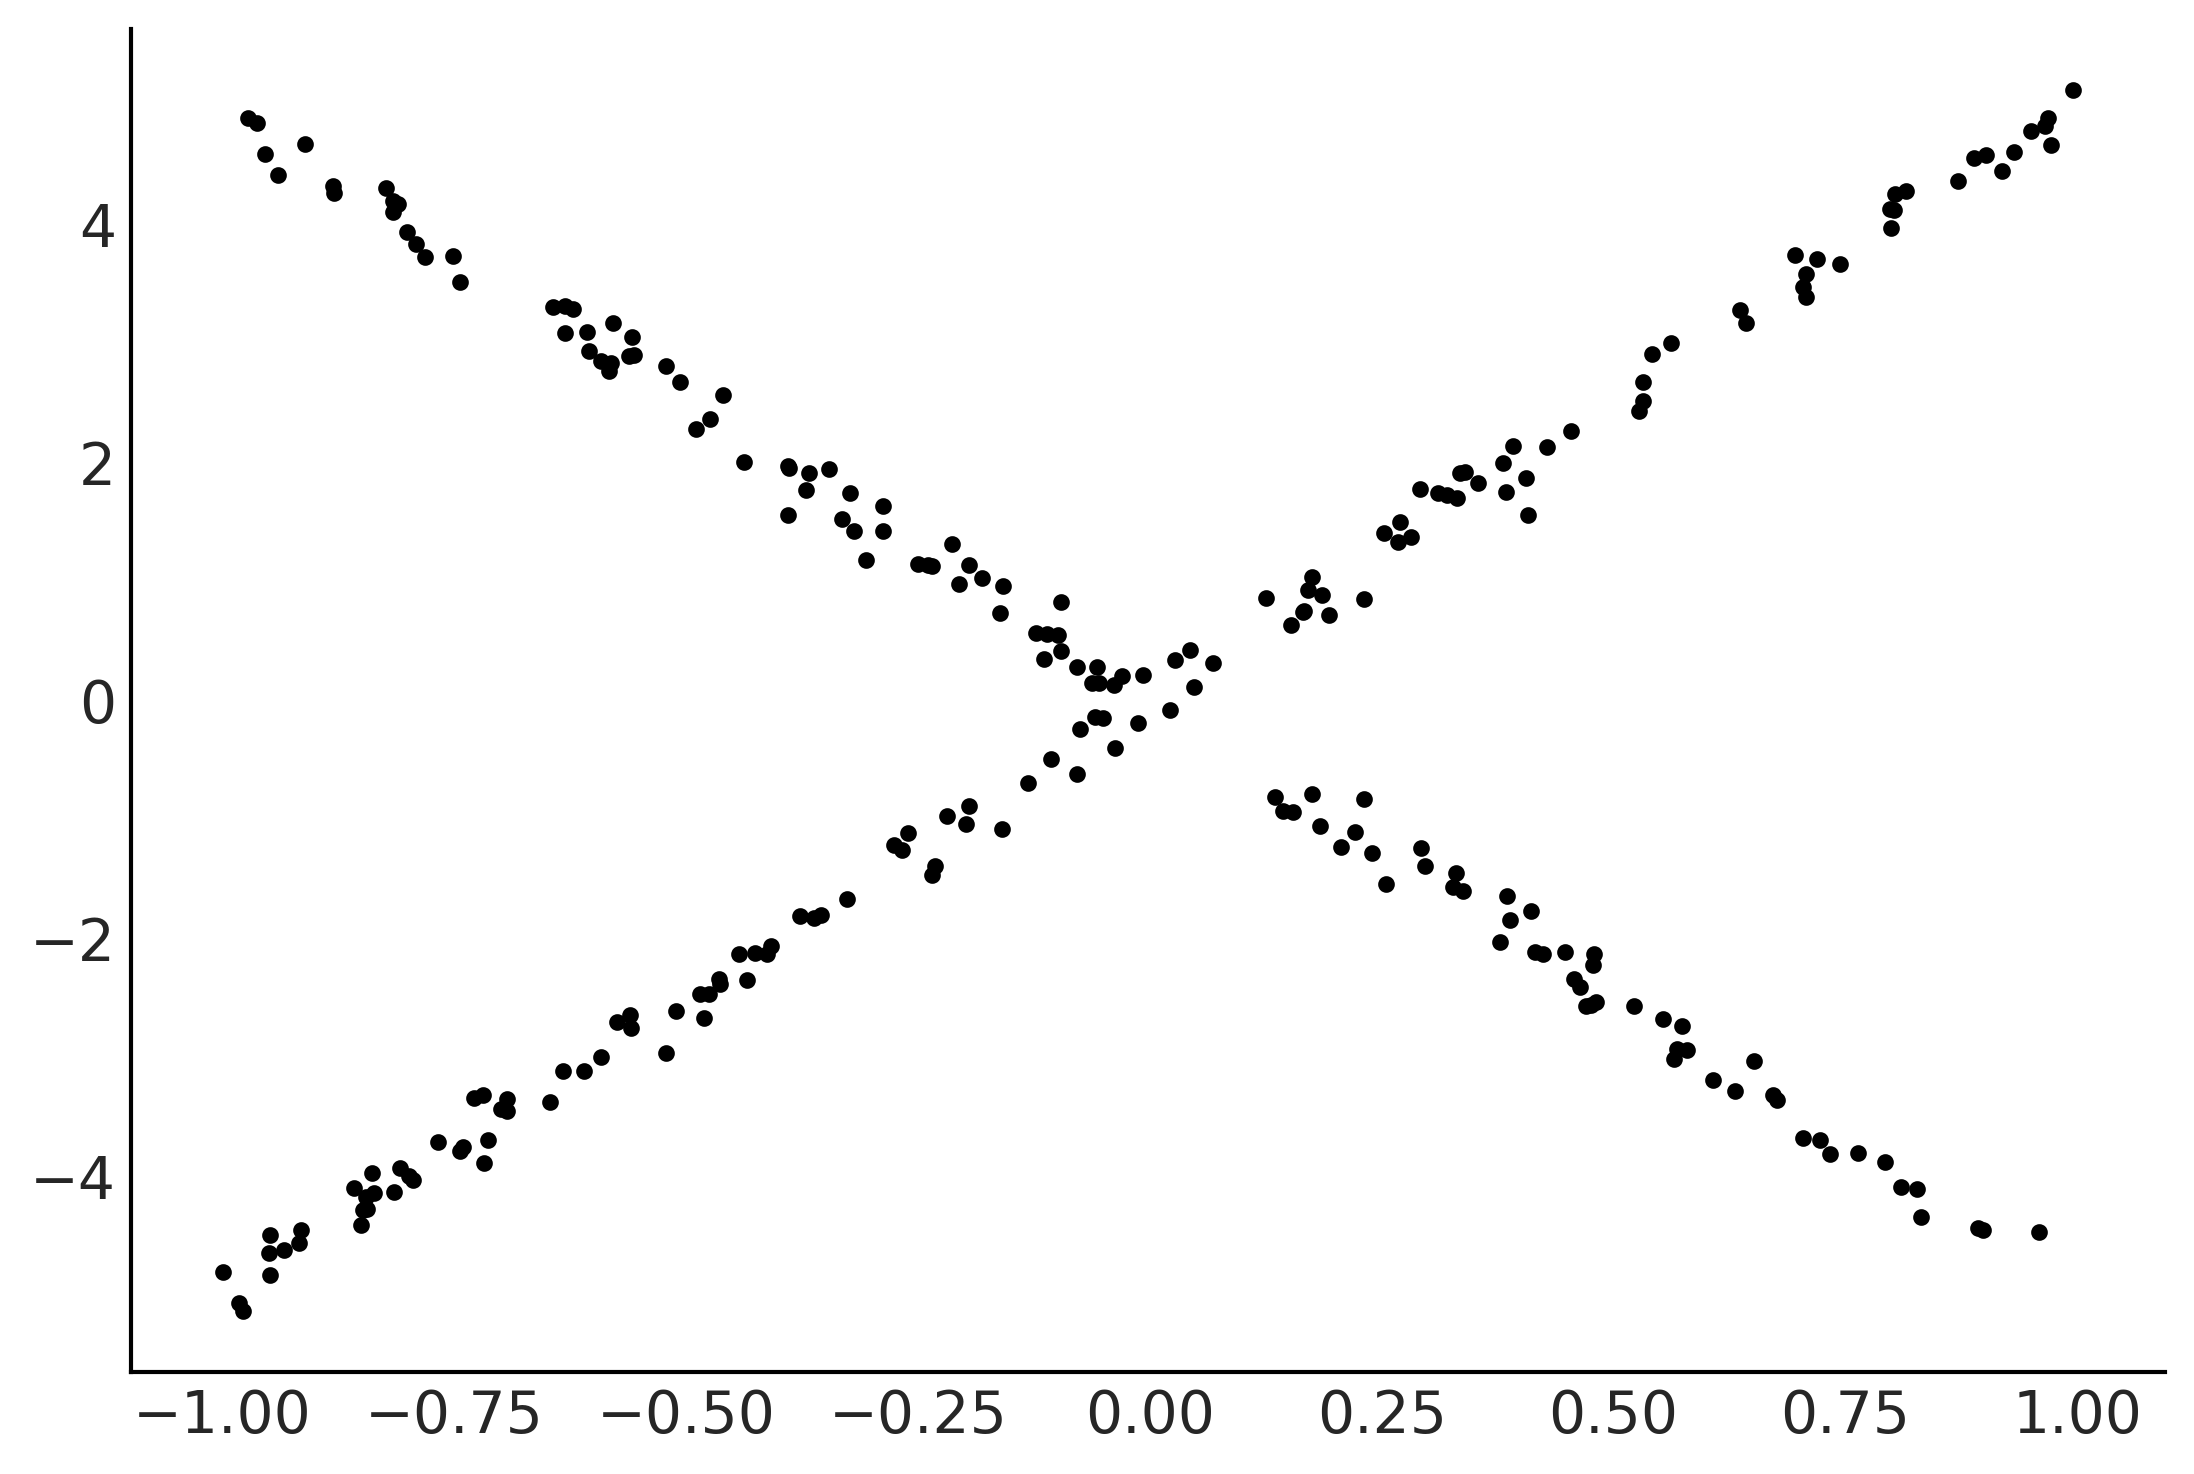

In [19]:
X = np.random.uniform(-1, 1, (250, 3))
lala = np.where(X[:,2] >= 0,  np.zeros_like(X[:,2]), np.ones_like(X[:,2]))
e = np.random.normal(0, 0.1, 250)
Y = 0.2*X[:,0] - 5*X[:,1] + 10*X[:,1] * lala+ e


plt.plot(X[:,1], Y, '.');

In [20]:
with pm.Model() as model:
    μ = pm.BART('μ', X, Y, m=50)
    σ = pm.HalfNormal('σ', 1)

    y = pm.Normal('y', μ, σ, observed=Y)
    trace_u = pm.sample(1000, tune=1000, chains=1)

/tmp/ipykernel_270170/2147951889.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_u = pm.sample(1000, tune=1000, chains=1)
The BART model is experimental. Use with caution.
Sequential sampling (1 chains in 1 job)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8979019284068072, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


[<AxesSubplot:xlabel='X_1'>]

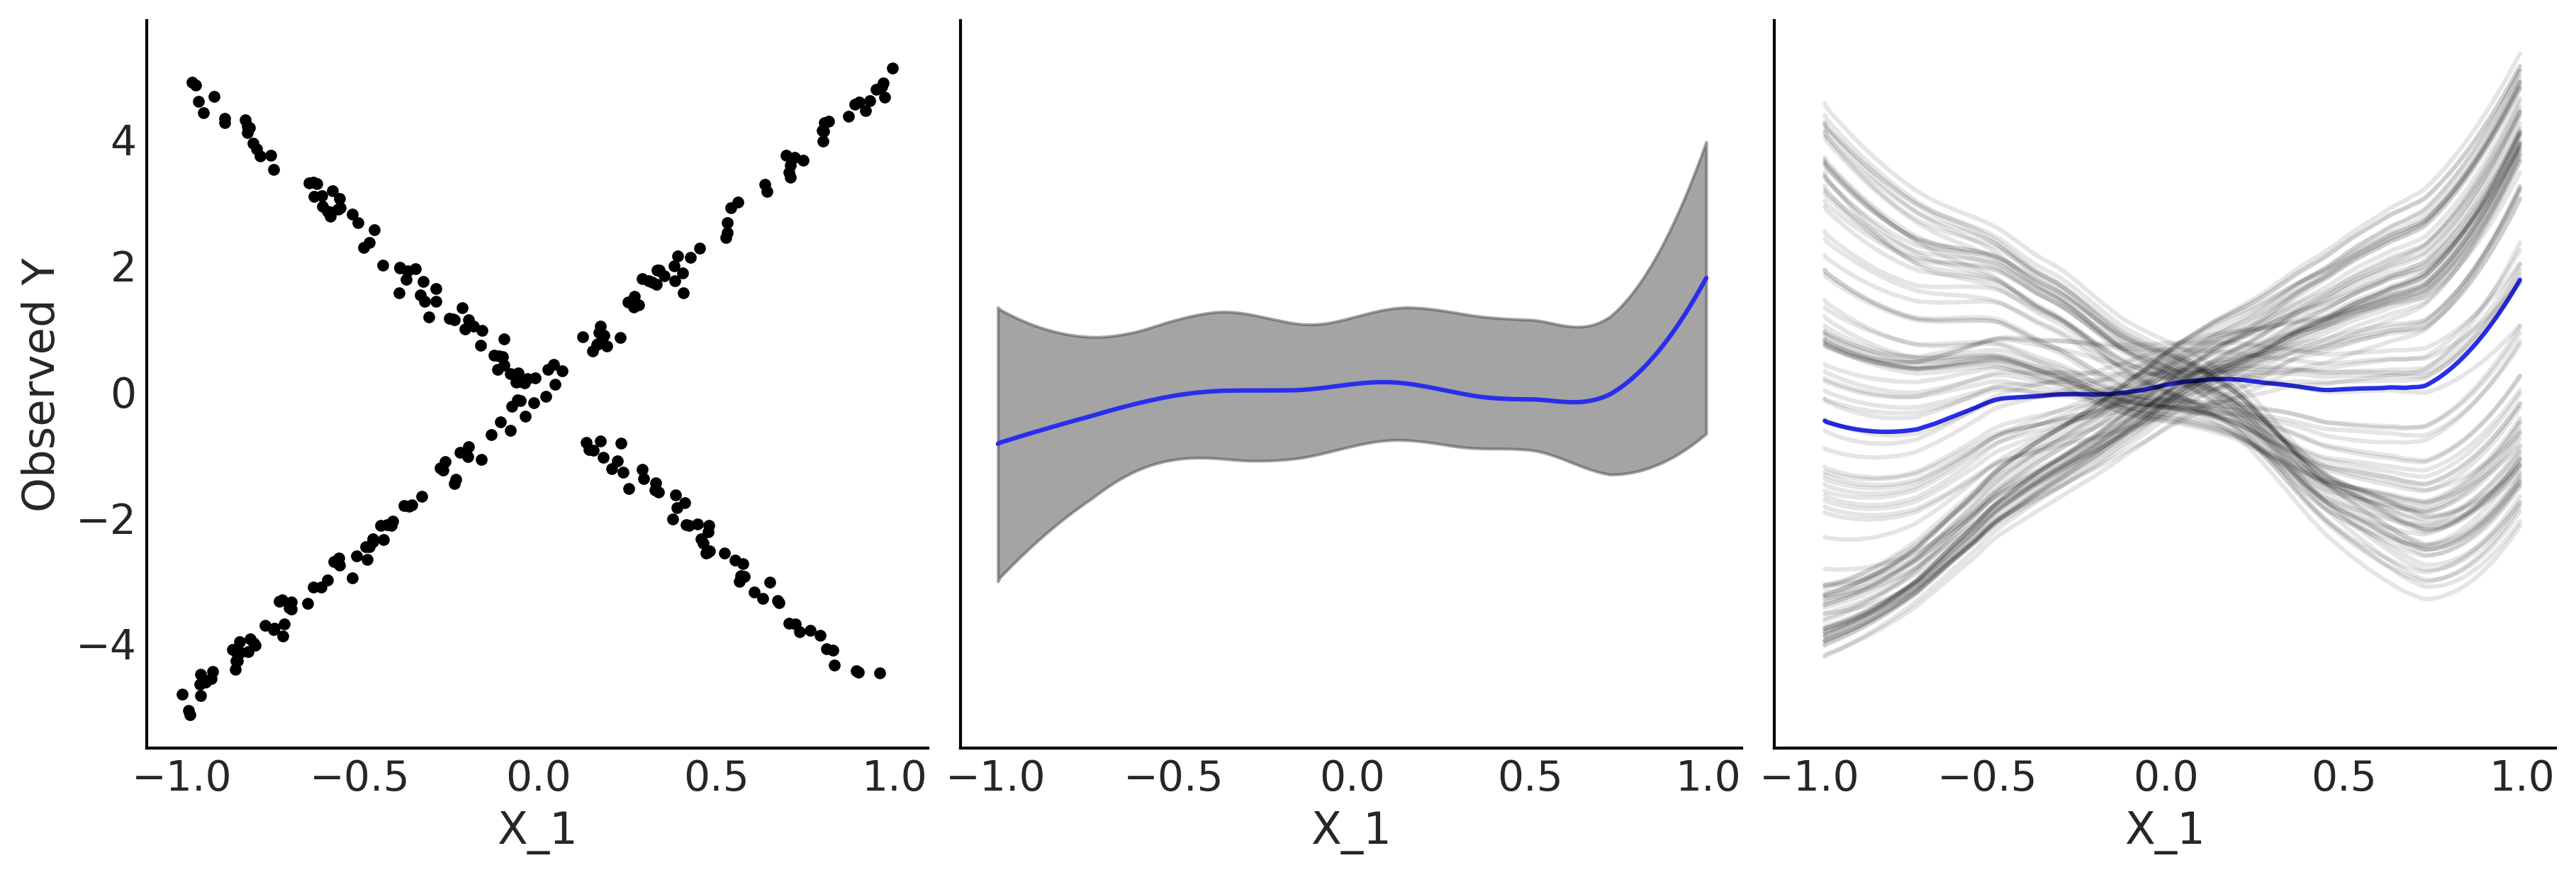

In [21]:
_, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
ax[0].plot(X[:,1], Y, '.');
ax[0].set_xlabel("X_1")
ax[0].set_ylabel("Observed Y")
plot_pdp(μ, X, style="pdp", smooth=True, color="C4", rug=False, var_idx=[1], ax=ax[1])
plot_pdp(μ, X, style="ice", smooth=True, subsample=100, color_mean="C4", rug=False, var_idx=[1], ax=ax[2])
# plt.savefig("img/chp07/pdp_vs_ice_toy.png", bbox_inches="tight")

## Variable Selection

In [22]:
Xs = []
Ys = []


Y = np.random.normal(0, 1, 100)
X = np.random.normal(0, 1, (100, 10))
X[:,0] = np.random.normal(Y, 0.1)
X[:,1] = np.random.normal(Y, 0.2)
Xs.append(X)
Ys.append(Y)


X = np.random.uniform(0, 1, size=(100, 10))
fx = 10 * np.sin(np.pi*X[:,0]* X[:,1]) + 20*(X[:,2] - 0.5)**2 + 10*X[:,3] + 5*X[:,4]
Y =  np.random.normal(fx, 1)
Xs.append(X)
Ys.append(Y)


Y = np.random.normal(0, 1, 100)
X = np.random.normal(0, 1, (100, 10))
Xs.append(X)
Ys.append(Y)

In [23]:
traces = []

for X, Y in zip(Xs, Ys):
    for m in [25, 50, 100, 200]:
        with pm.Model() as bart:
            σ = pm.HalfNormal('σ', Y.std())
            μ = pm.BART('μ', X, Y, m=m)
            y = pm.Normal('y', μ, σ, observed=Y)
            traces.append(pm.sample())

/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8904781801265796, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The acceptance probability does not match the target. It is 0.8880257768211871, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9159652881723734, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
The acceptance probability does not match the target. It is 0.8909777099618932, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849148384408957, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
The acceptance probability does not match the target. It is 0.8943915314467087, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8940790569156896, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The number of effective samples is smaller than 25% for some parameters.
/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
The acceptance probability does not match the target. It is 0.6362790367776981, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8965109257824564, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.
/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
The acceptance probability does not match the target. It is 0.8801274888380406, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909926981313567, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/tmp/ipykernel_270170/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
The acceptance probability does not match the target. It is 0.8794420103654305, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


### Figure 7.12

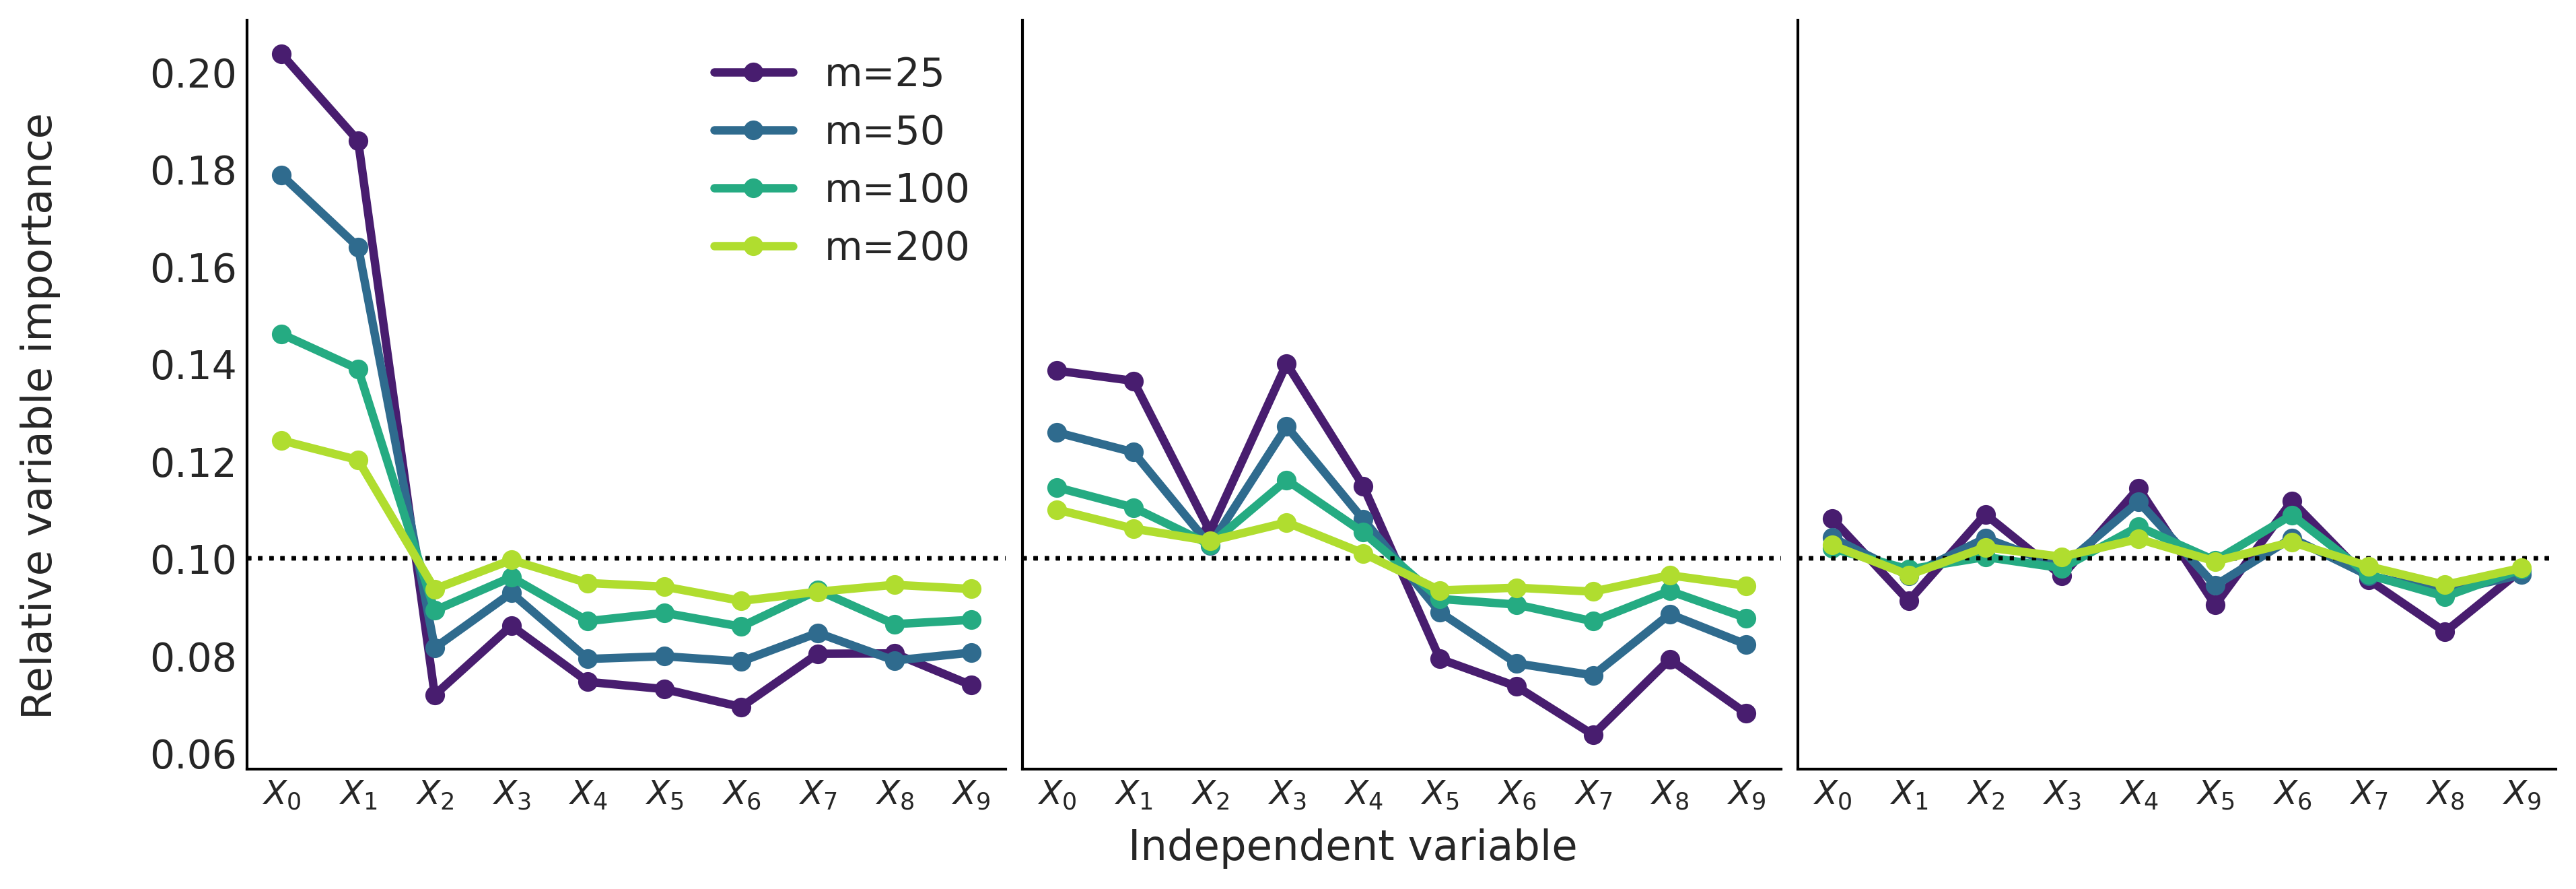

In [24]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
ax = np.ravel(ax)

count = 0
for j, X in enumerate(Xs):
    ax[j].set_prop_cycle(cycler('color', viridish))
    for i, m in enumerate([25, 50, 100, 200]):
        ax[j].axhline(1/X.shape[1], color="k", ls=":")
        ax[j].plot(traces[count].report.variable_importance, label=f"m={m}", lw=3, marker="o")
        ax[j].set_xticks(range(X.shape[1]))
        ax[j].set_xticklabels([f"$X_{i}$" for i in range(X.shape[1])], fontsize=12)

        count += 1
fig.text(0.5, -0.05, 'Independent variable', ha='center', fontsize=15)
fig.text(-0.05, 0.5, 'Relative variable importance', va='center', rotation='vertical', fontsize=15)
ax[0].legend()
        
# plt.savefig("img/chp07/bart_vi_toy.png", bbox_inches="tight")

In [25]:
data = pd.read_csv("data/bikes_hour.csv")
data.sort_values(by='hour', inplace=True)
data = data[::50]
X = data[["hour", "temperature", "humidity", "windspeed"]]
Y = data["count"]

In [26]:
traces = []

for m in [25, 50, 100]:
    with pm.Model() as bart:
        σ = pm.HalfNormal('σ', Y.std())
        μ = pm.BART('μ', X, Y, m=m)
        y = pm.Normal('y', μ, σ, observed=Y)
        traces.append(pm.sample())

/tmp/ipykernel_270170/789580105.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_270170/789580105.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.
/tmp/ipykernel_270170/789580105.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
The acceptance probability does not match the target. It is 0.8890640855938627, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### Figure 7.13

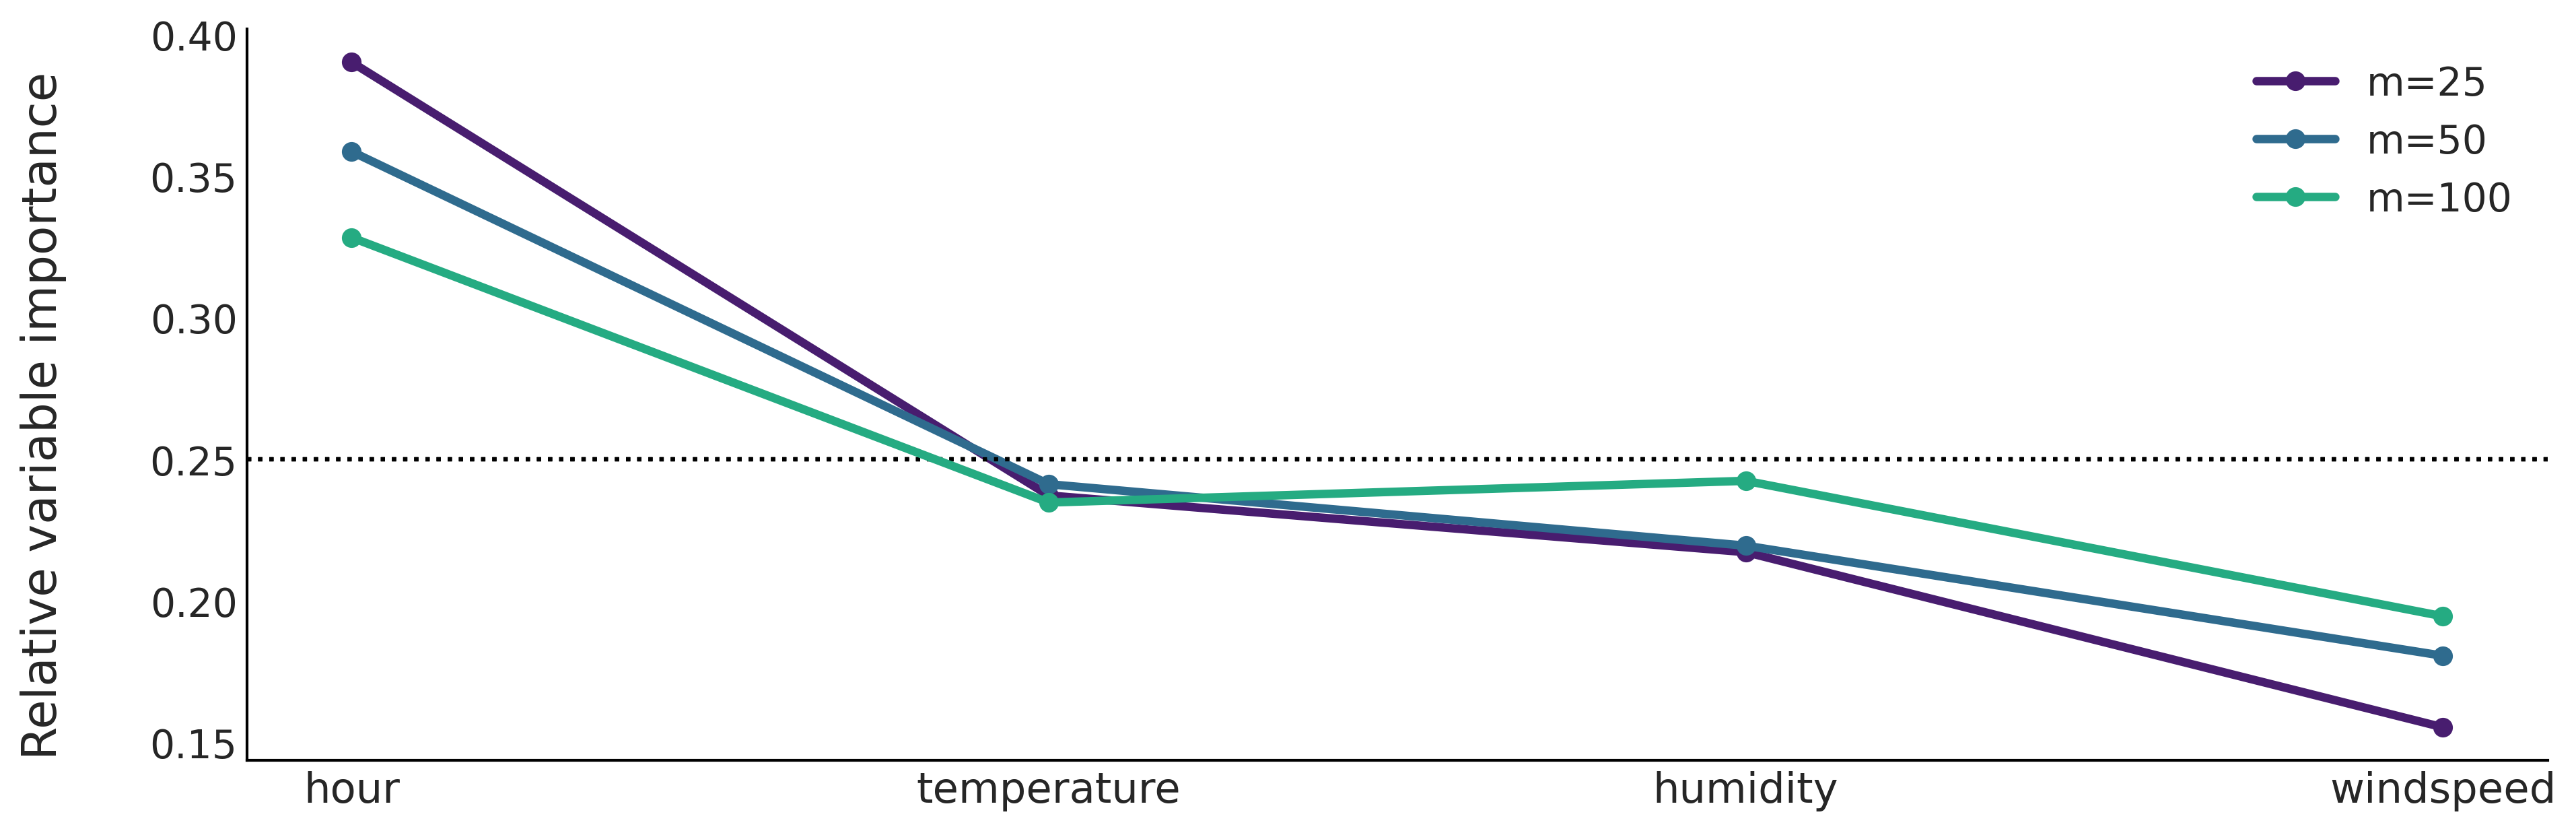

In [27]:
fig, ax = plt.subplots(sharey=True, figsize=(12, 4))
ax.set_prop_cycle(cycler('color', viridish))
ax = np.ravel(ax)

count = 0
for i, m in enumerate([25, 50, 100]):
    ax[0].axhline(1/X.shape[1], color="k", ls=":")
    ax[0].plot(traces[count].report.variable_importance, label=f"m={m}", lw=3, marker="o")
    ax[0].set_xticks(range(X.shape[1]))
    ax[0].set_xticklabels([label for label in X.columns], fontsize=15)

    count += 1
fig.text(-0.05, 0.5, 'Relative variable importance', va='center', rotation='vertical', fontsize=17)
ax[0].legend()
        
# plt.savefig("img/chp07/bart_vi_bikes.png", bbox_inches="tight")